In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import NuestrasFunciones

In [3]:
df_titanic = pd.read_csv("In/train.csv")

In [4]:
df_titanic.rename(columns = {"SibSp": "SiblingsSpouses","Parch":"ParentsChildren"},inplace = True)

In [5]:
df_titanic.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [6]:
def contar_valores(df,max_valores = 5):
    for i in df.columns:
        if df[i].nunique() < max_valores:
            print(f"value counts de {df[i].name} es:")
            print(df[i].value_counts(dropna= False))
            print("--------------------------------")

In [7]:
contar_valores(df_titanic,max_valores = 20)

value counts de Survived es:
0    549
1    342
Name: Survived, dtype: int64
--------------------------------
value counts de Pclass es:
3    491
1    216
2    184
Name: Pclass, dtype: int64
--------------------------------
value counts de Sex es:
male      577
female    314
Name: Sex, dtype: int64
--------------------------------
value counts de SiblingsSpouses es:
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SiblingsSpouses, dtype: int64
--------------------------------
value counts de ParentsChildren es:
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: ParentsChildren, dtype: int64
--------------------------------
value counts de Embarked es:
S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64
--------------------------------


### Bajo age, ParentsChildren = 0 significa niño solo.

Cont


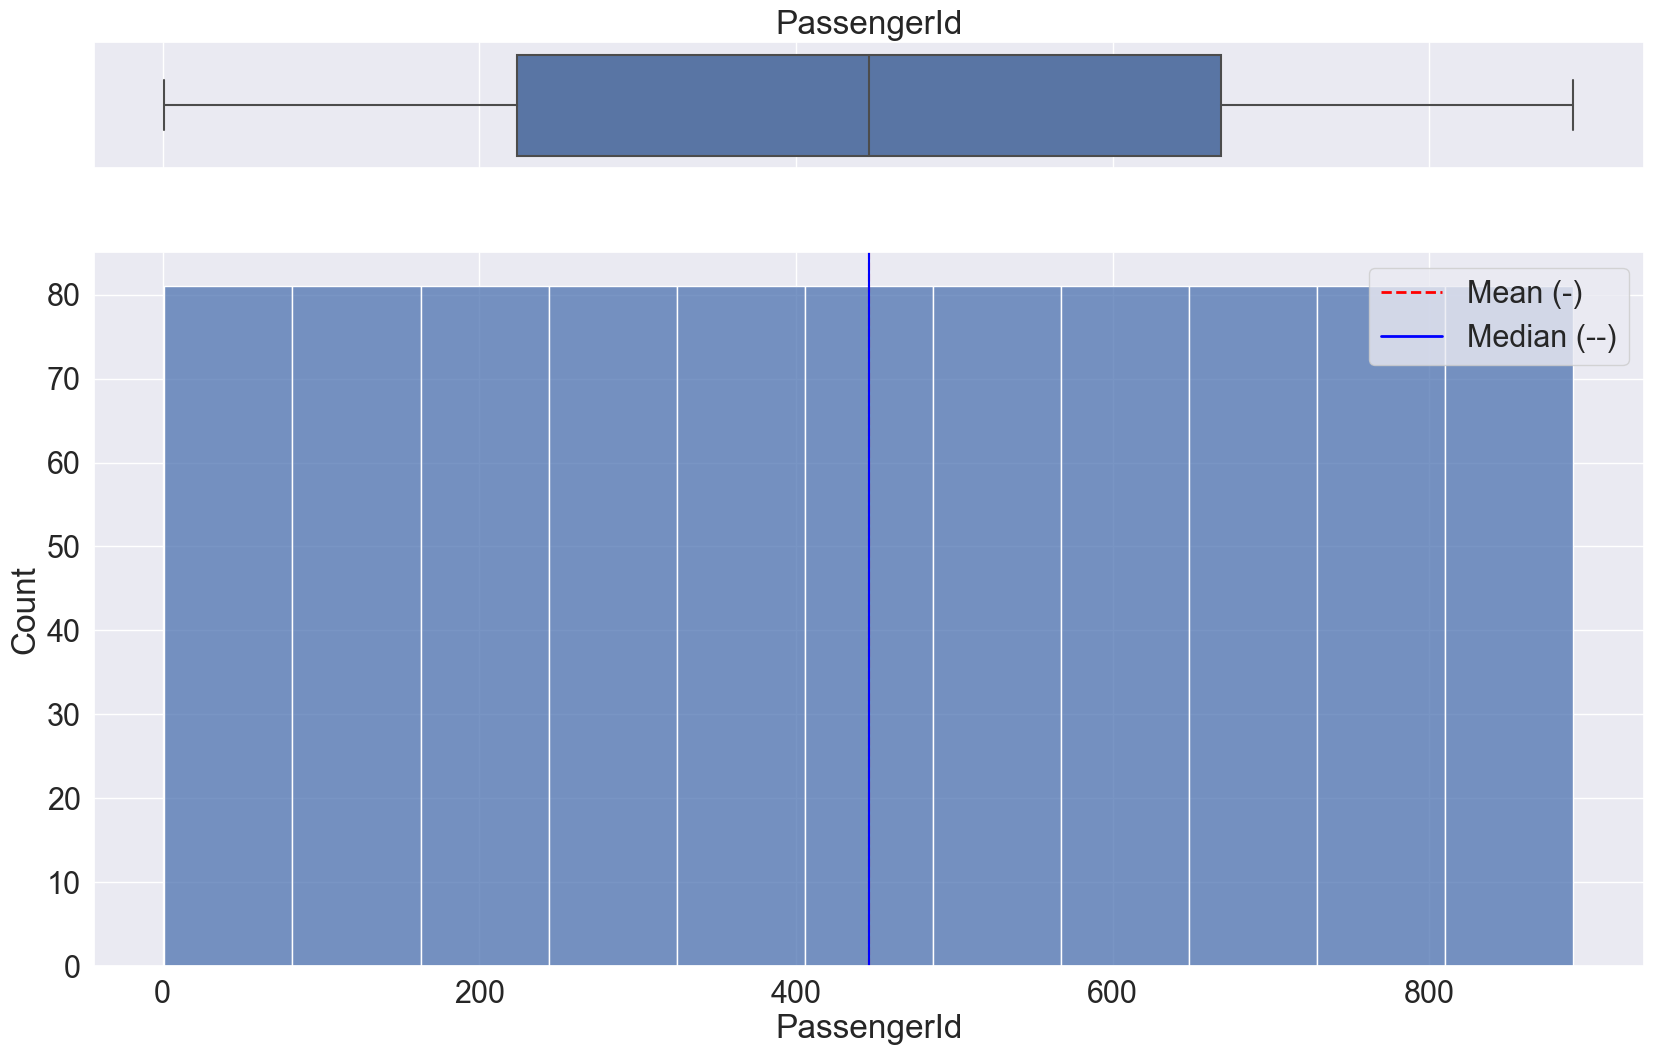

Cont


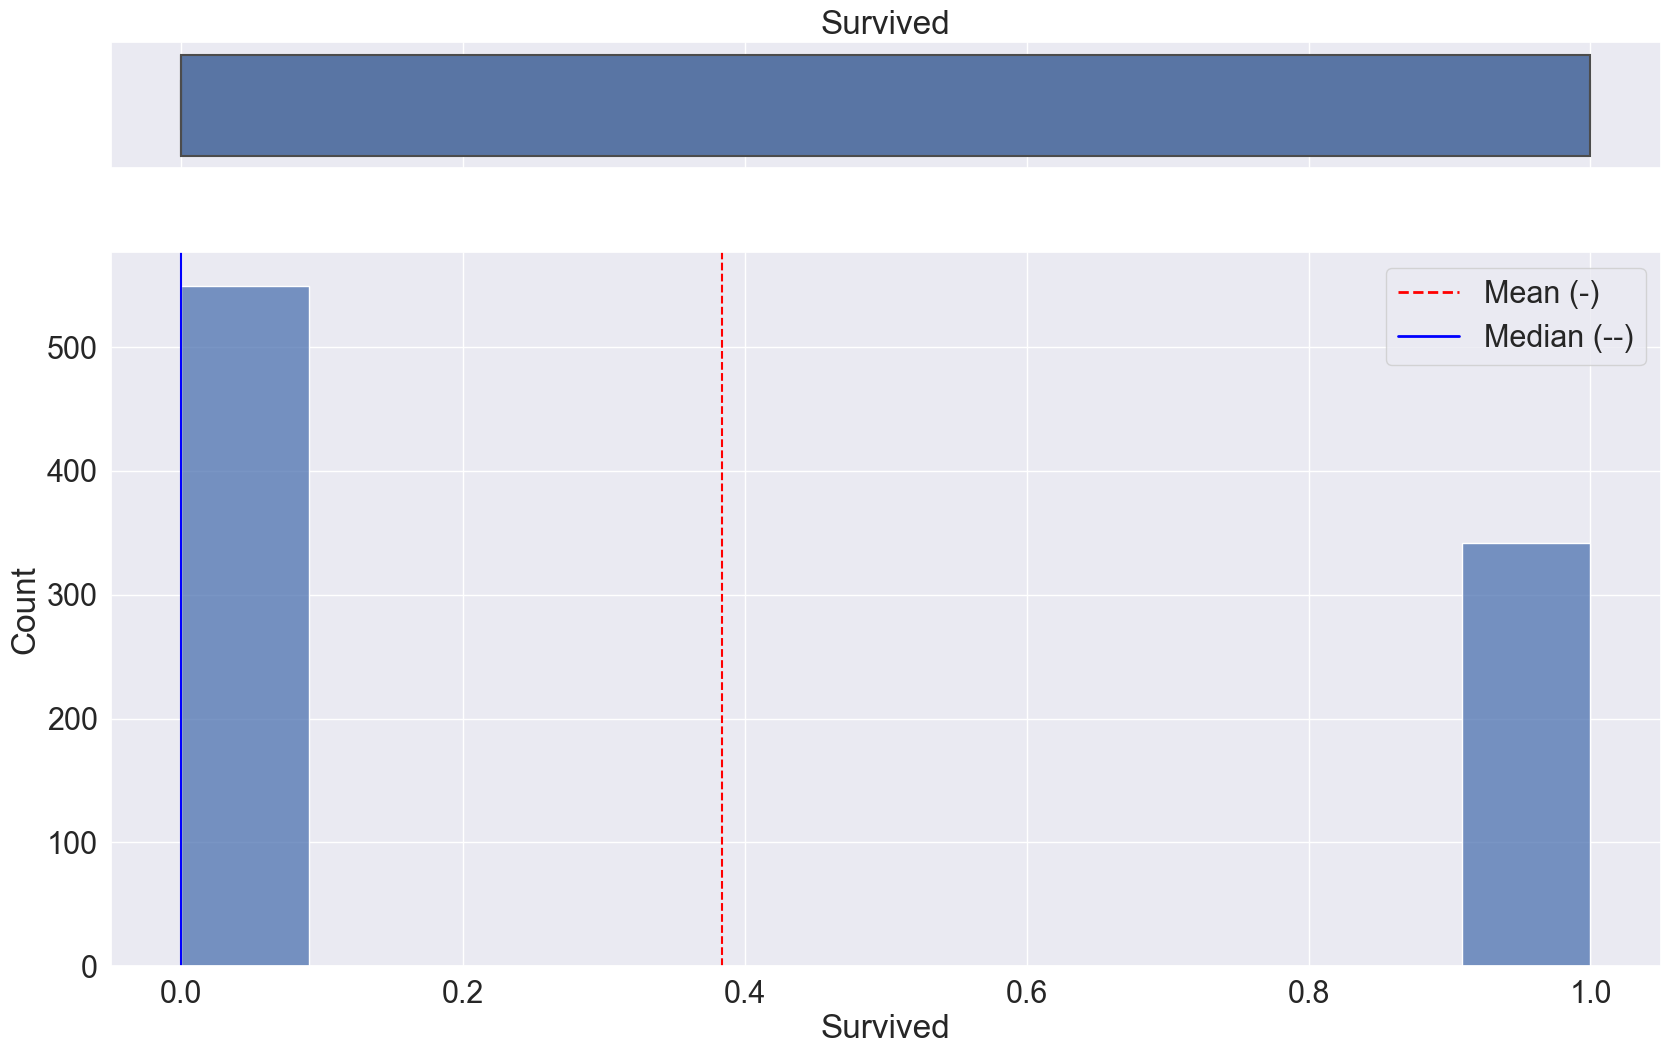

Cont


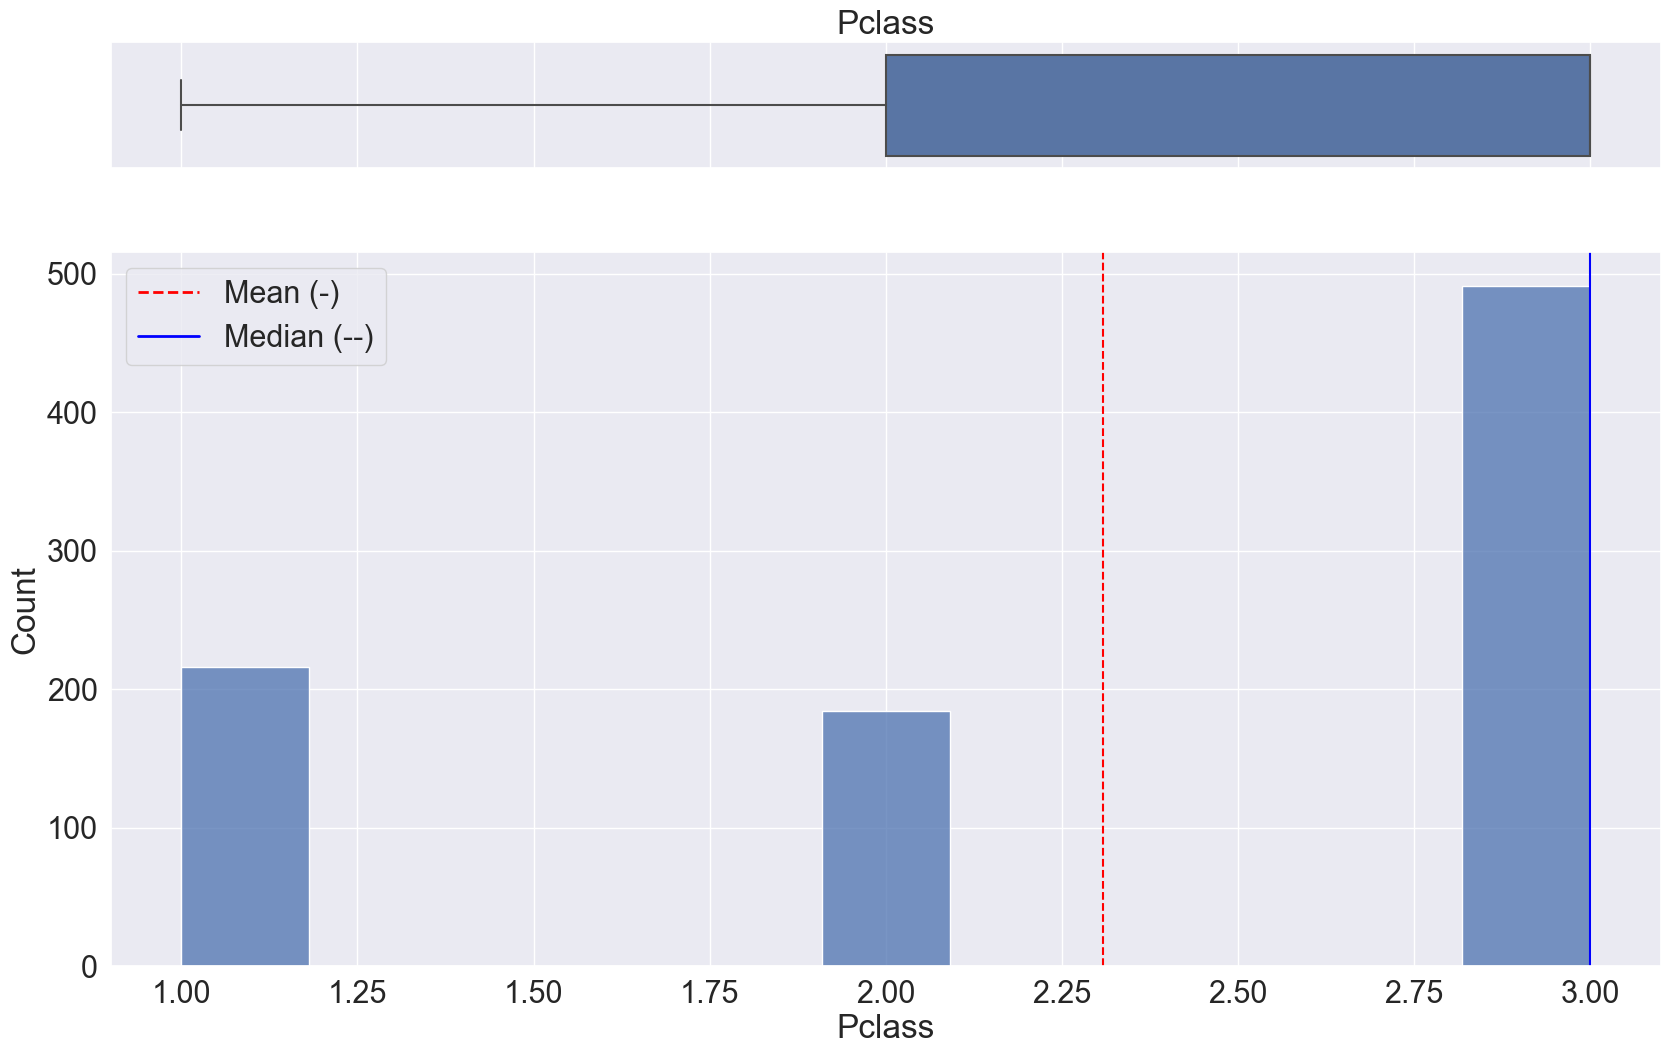

Change column: Name to another data type
Change column: Sex to another data type
Cont


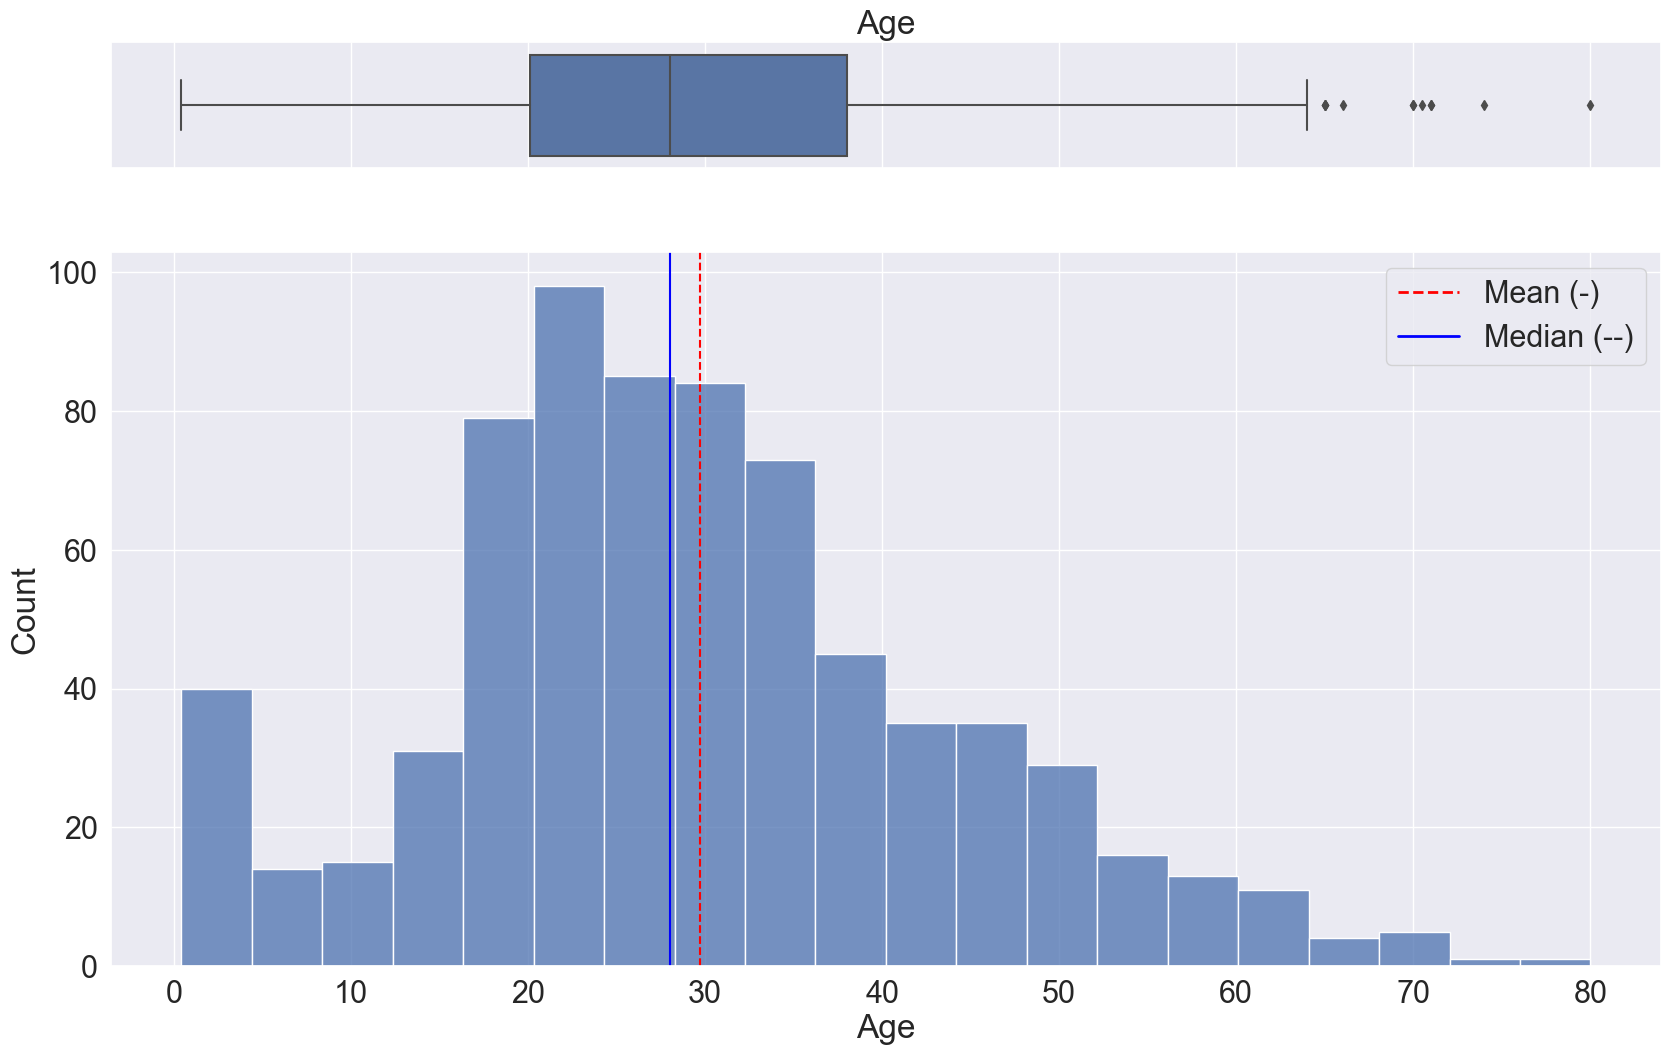

Cont


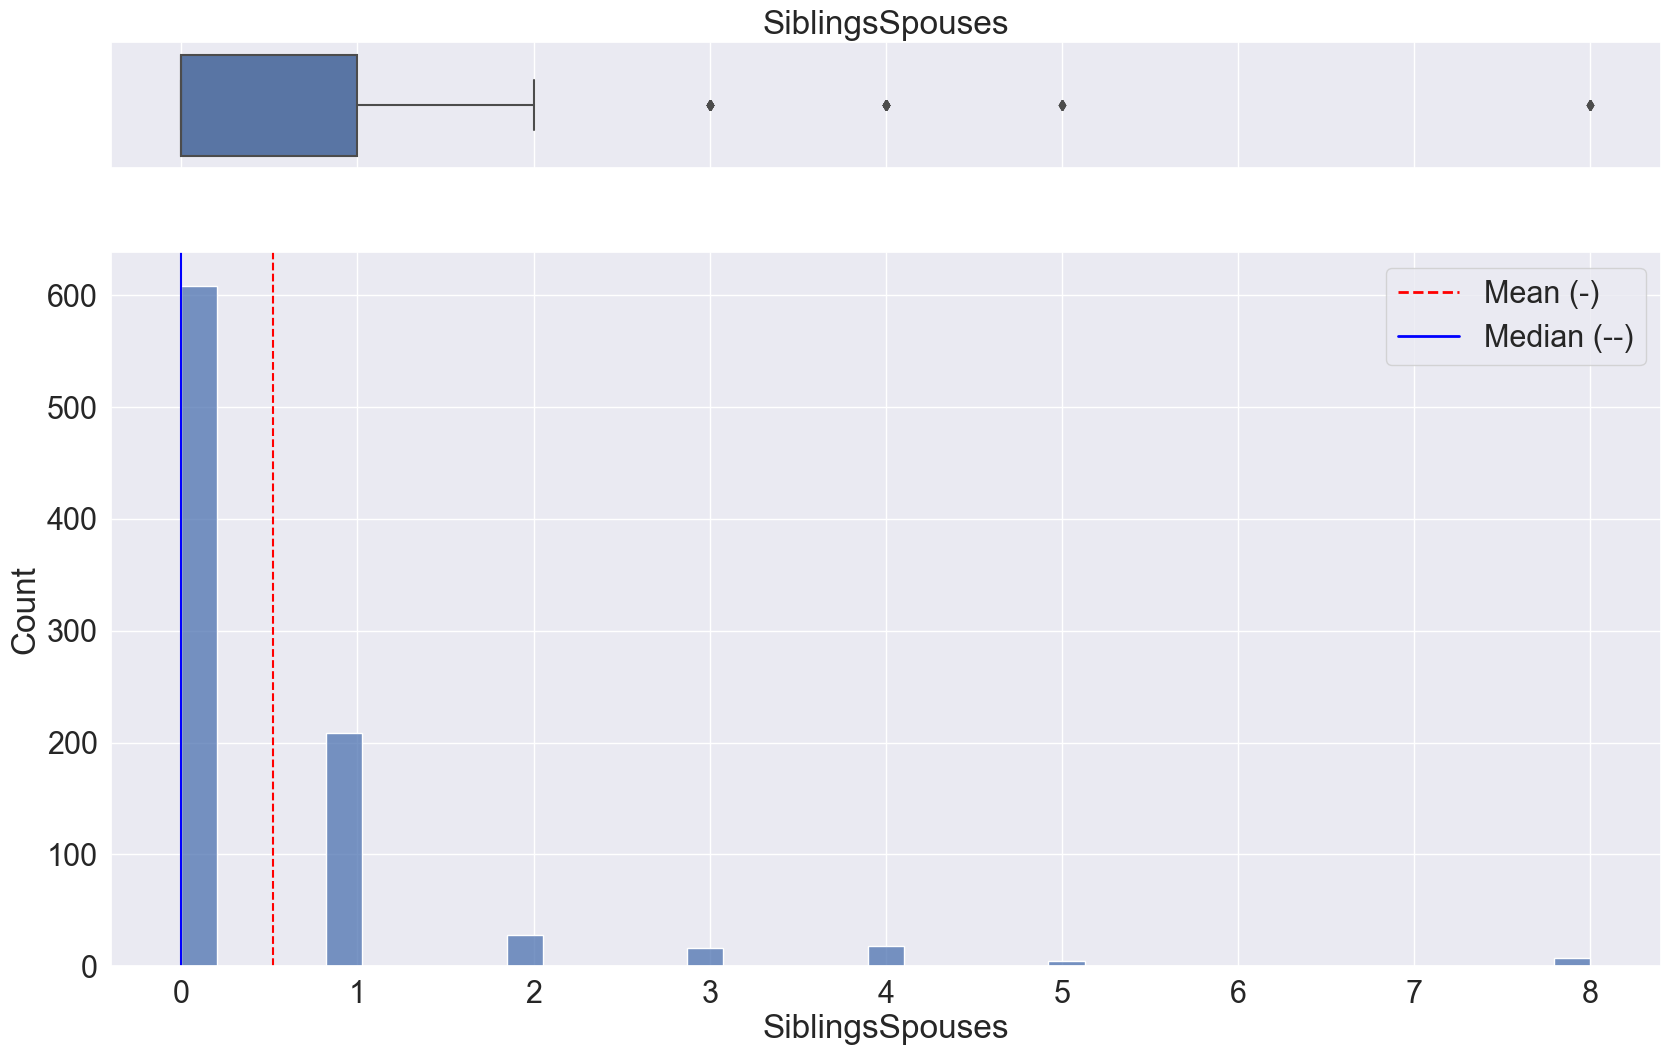

Cont


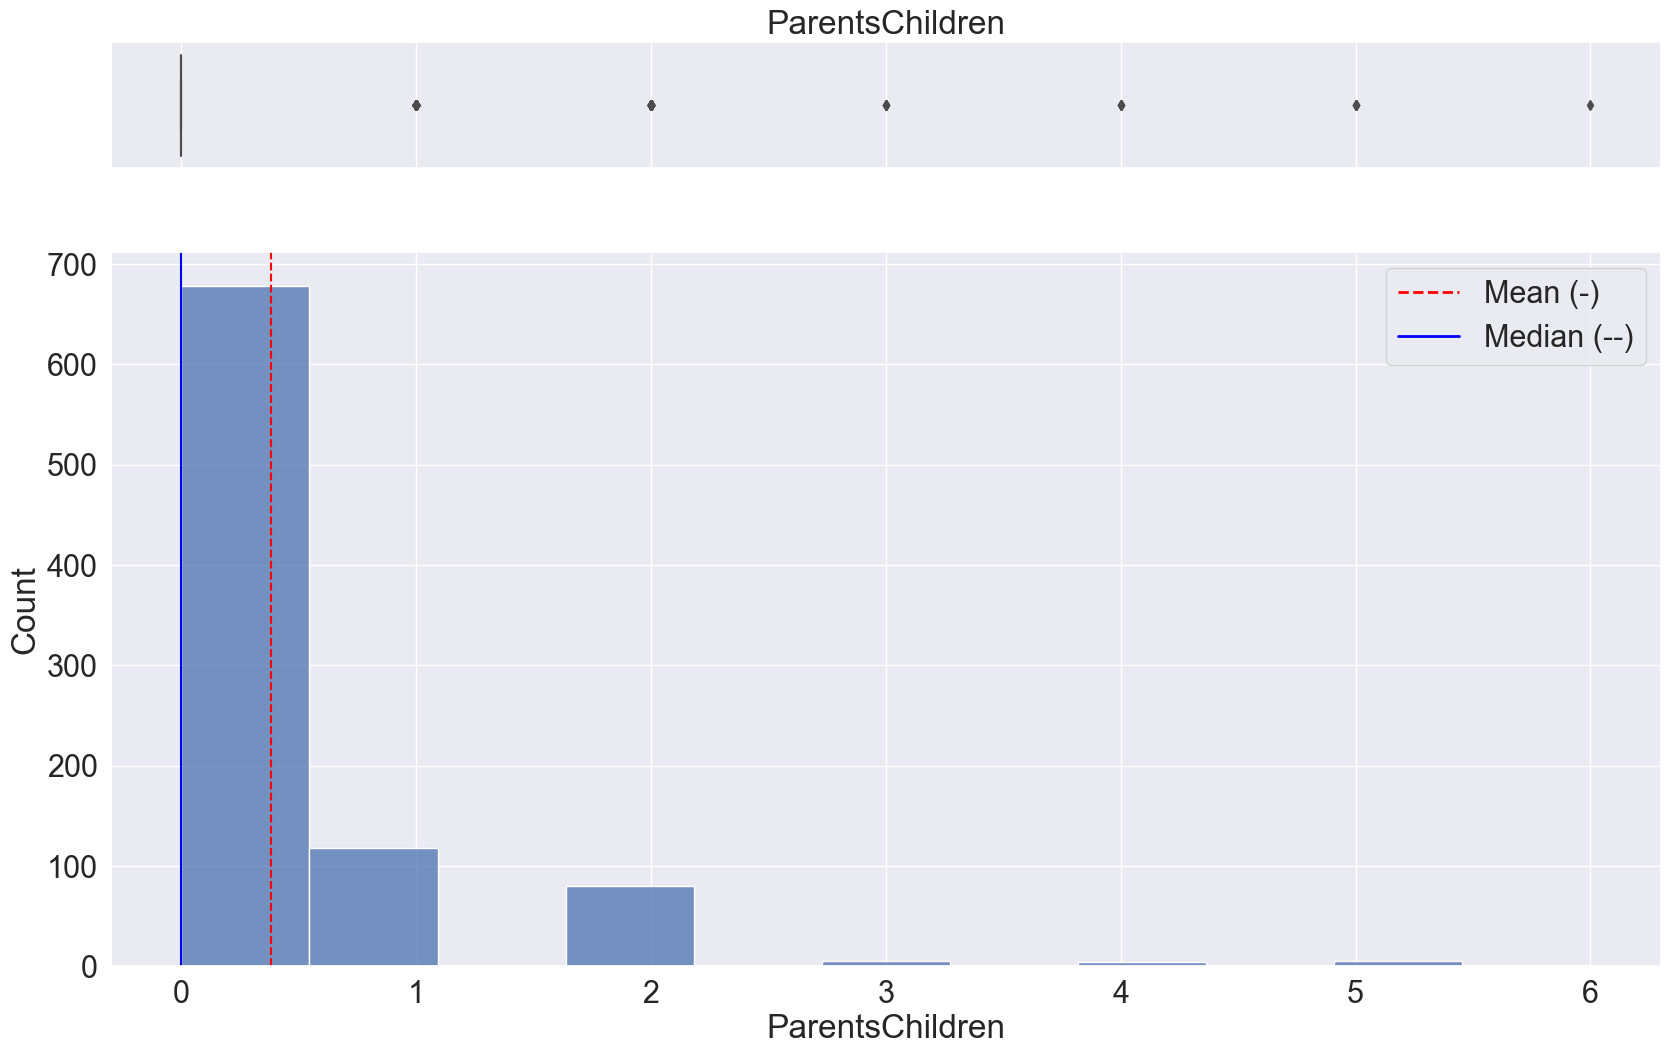

Change column: Ticket to another data type
Cont


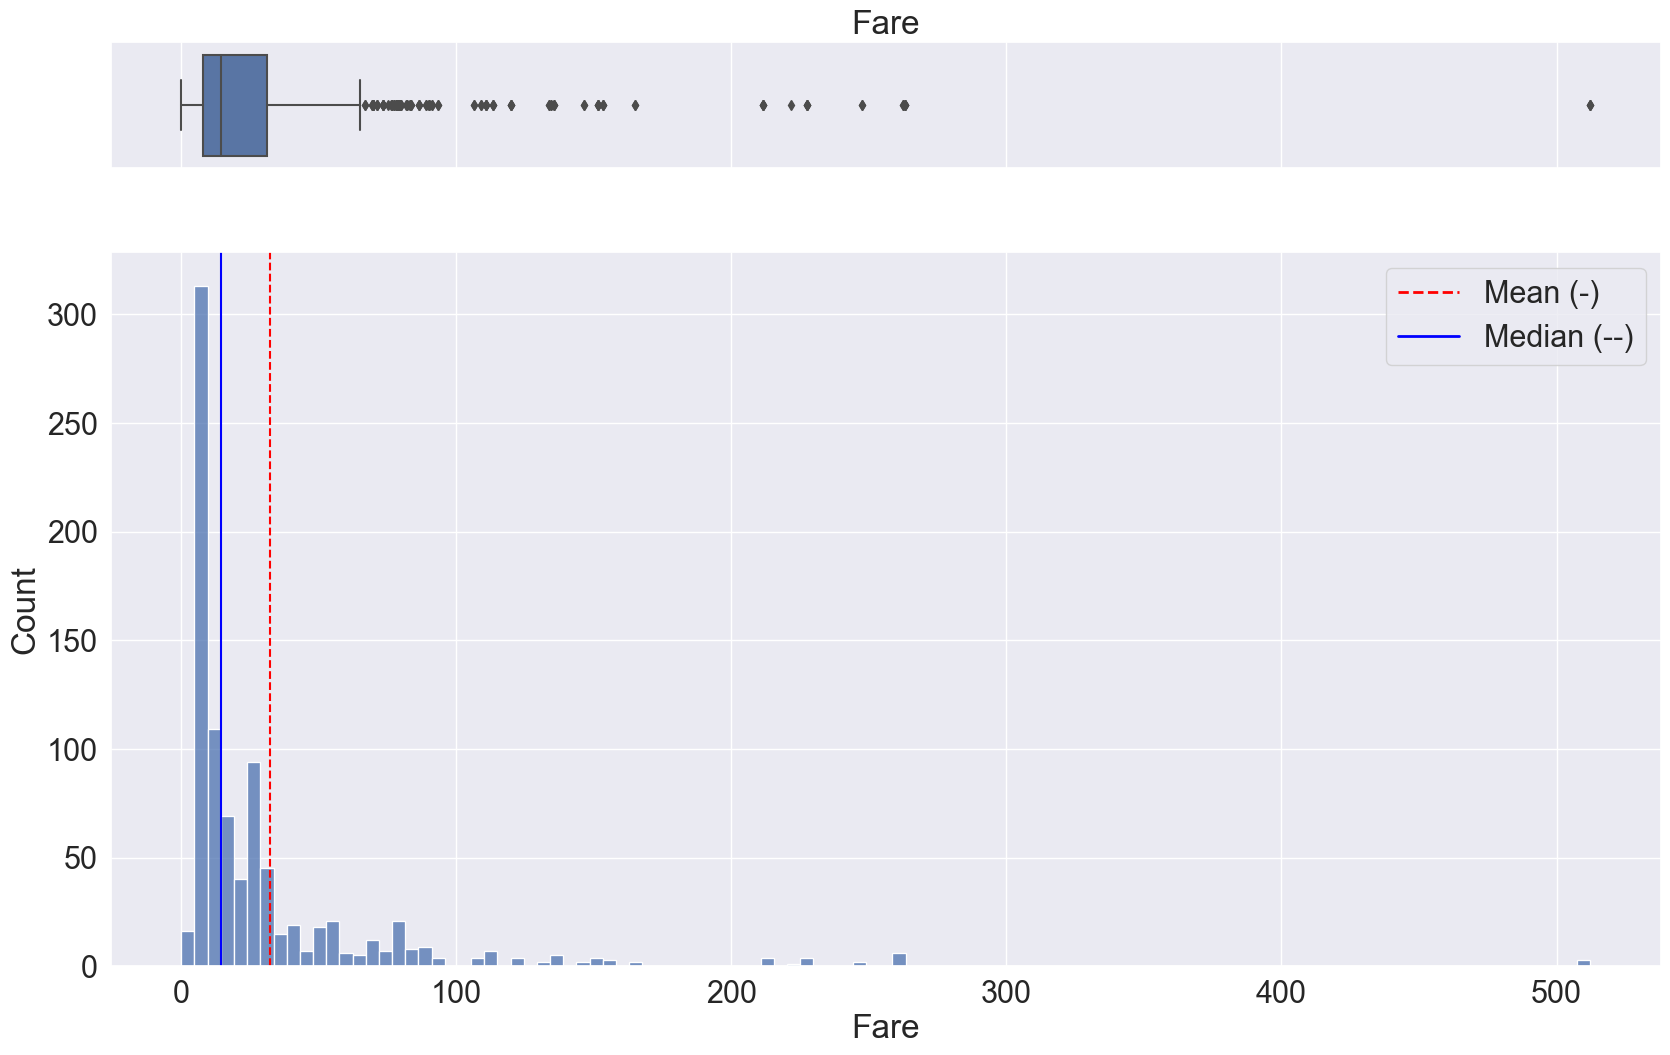

Change column: Cabin to another data type
Change column: Embarked to another data type


PassengerId        None
Survived           None
Pclass             None
Name               None
Sex                None
Age                None
SiblingsSpouses    None
ParentsChildren    None
Ticket             None
Fare               None
Cabin              None
Embarked           None
dtype: object

In [8]:
#df_titanic.drop(["Name","Sex","Ticket","Cabin","Embarked"],axis=1).apply(NuestrasFunciones.plot)
df_titanic.apply(NuestrasFunciones.plot)

In [9]:
df_titanic.apply(lambda x: x.isna().sum())

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                177
SiblingsSpouses      0
ParentsChildren      0
Ticket               0
Fare                 0
Cabin              687
Embarked             2
dtype: int64

In [10]:
df_titanic.Cabin.describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

### Personas con misma cabin puede dar juego, especialmente porque instrucciones dicen algo de mistresses.

### Las NA se deben poder conseguir en apellidos!

In [11]:
df_titanic.Age.describe()
#Puede que valga la pena tramificar
#Se debe poder sacar el NA con SiblingsSpouse y apellido!! Ambas columnas sin NA

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [12]:
df_titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SiblingsSpouses', 'ParentsChildren', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')

# Se cambia sex a dicotómica 1=male ; 0=female 

In [13]:
df_titanic.Sex

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [14]:
df_titanic.loc[df_titanic["Sex"] == "male", "Sex"] = 1
df_titanic.loc[df_titanic["Sex"] == "female", "Sex"] = 0
df_titanic["Sex"] = df_titanic["Sex"].astype("category")

<Axes: >

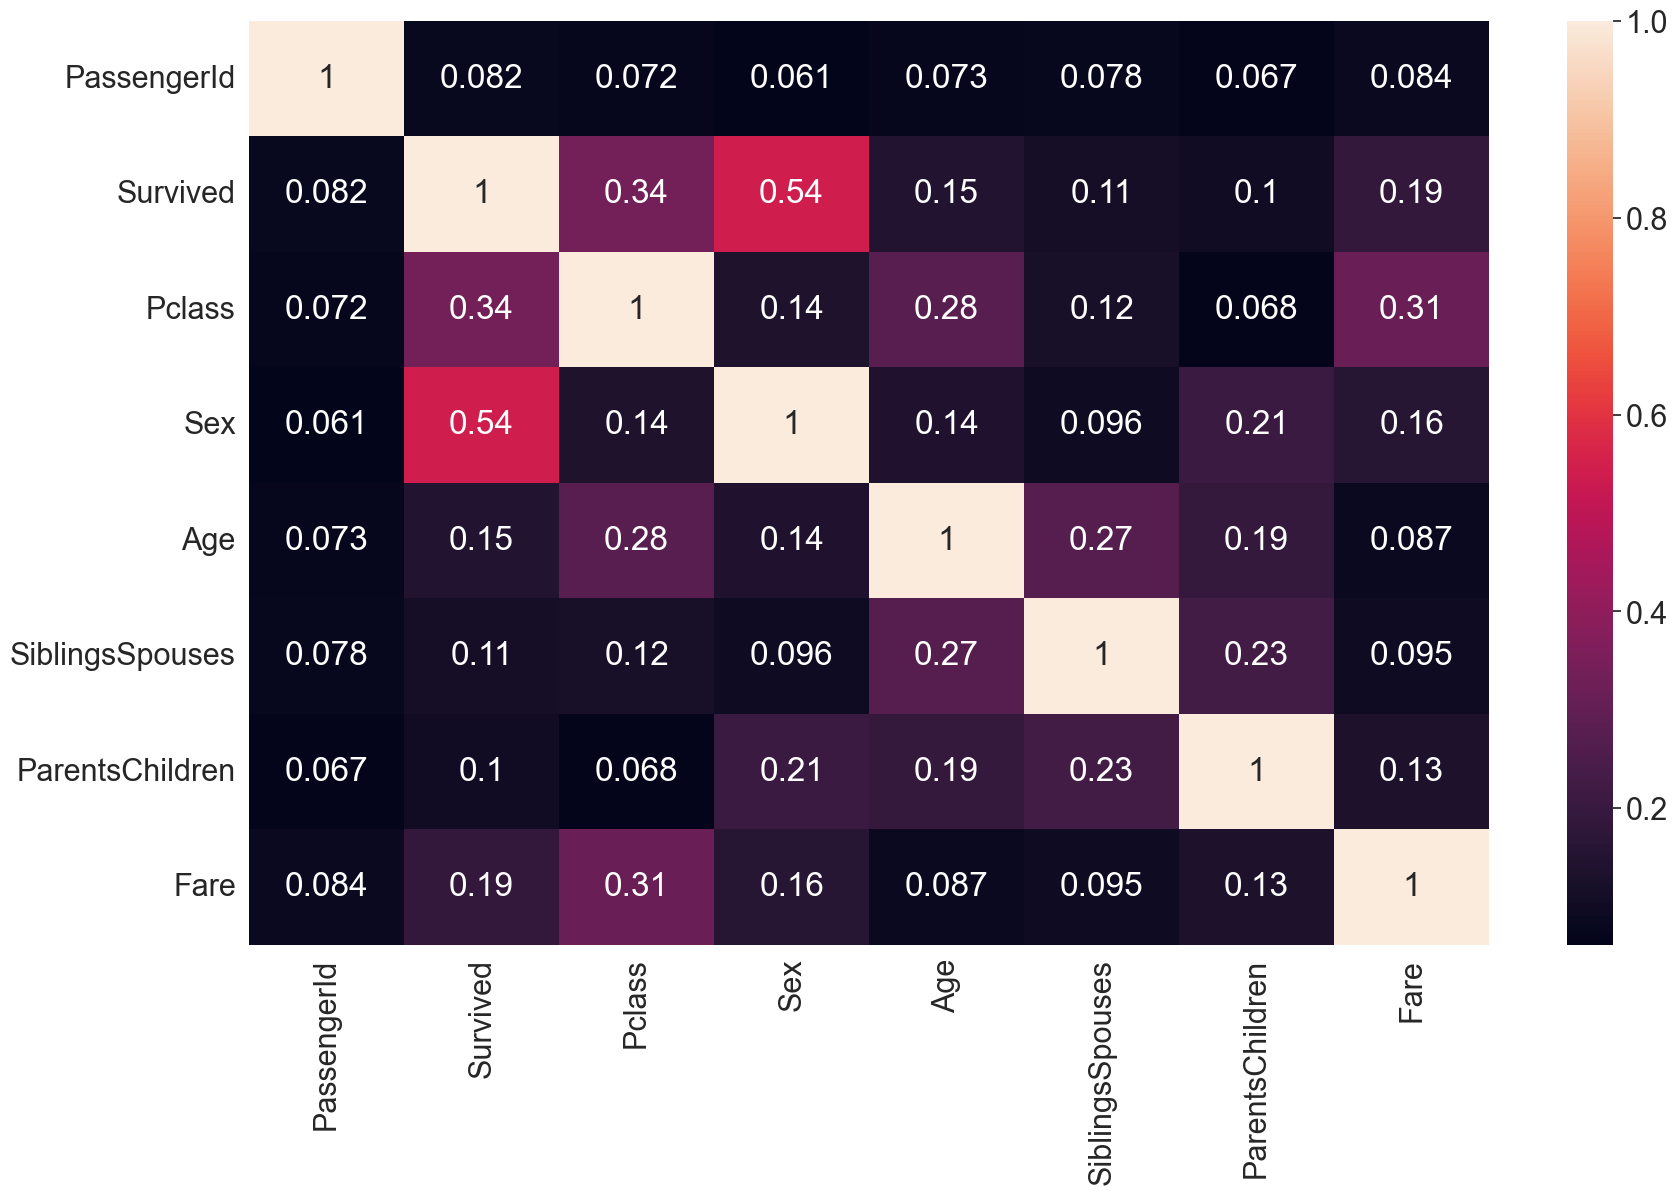

In [15]:
corr = NuestrasFunciones.get_cat_corr_mat(df_titanic.select_dtypes(exclude = "object"))
plt.rcParams["figure.figsize"] = (20, 12)
sns.heatmap(corr, annot=True)

# Se busca qué hacer con Ticket

# Personas con el mismo Ticket deben estar acompañados

In [16]:
x = df_titanic['Ticket'].apply(lambda x: x.split(" "))
df_titanic["PostTicket"] = [i[1] if len(i) == 2 else i[0] for i in x]

df_titanic.Ticket = df_titanic.Ticket.apply(lambda x: x.replace(",","").replace(".","").replace("/","").upper())


#String operations para unir diferentes PreTickets que parecen ser los mismos, eliminar comas, puntos y upper por SCPARIS
#Pudiese seguir uniendo parecidas pero sería por adivinanza

In [17]:
### Hay más agrupación en la segunda parte del ticket que en el ticket entero.
### Vale la pena buscar en post ticket la cantidad de acompañantes.

### Testear con Ticket y Post ticket en pipeline y ver Cuál da mejor resultado en Cross-validation.

In [18]:
def cant_mismo_ticket(tick,ser):
    lista = []
    val_counts = ser.value_counts()
    valor = val_counts[tick] -1
    return valor

df_titanic["Cant_PersonasMismoTicket"] = df_titanic.Ticket.apply(lambda x: cant_mismo_ticket(x,df_titanic.Ticket))
valor_cramer = NuestrasFunciones.cramers_v(df_titanic.Cant_PersonasMismoTicket,df_titanic.Survived)

array_con_postTicket = df_titanic.PostTicket.apply(lambda x: cant_mismo_ticket(x,df_titanic.PostTicket))
valor_cramer_con_postTicket = NuestrasFunciones.cramers_v(array_con_postTicket,df_titanic.Survived)

print(f"La variable creada que muestra cantidad de acompañantes tiene un valor de V de Cramer con la objetivo de: {valor_cramer}")
print(f"Valor de V de Cramer si asociamos por post-ticket: {valor_cramer_con_postTicket}")


La variable creada que muestra cantidad de acompañantes tiene un valor de V de Cramer con la objetivo de: 0.22866234689920364
Valor de V de Cramer si asociamos por post-ticket: 0.11275719863489767


### Intentando la misma columna buscando iguales en sólo PostTicket da un valor de asociación de cramer mucho peor. Haré igualmente check en cross validation para estar seguro de no estar sobre ajustando al training.

# Qué son los tickets con cosas antes??

### - No hay suficientes observaciones como para hacer one hot enconding de cada posible PreTicket.

### Dejo comentadas unas métricas con V de Cramer catastrófica:

In [19]:
#Primero investigo si la diferencia radica en desconocido o no, malos resultados.
#df_investigacion1.PreTicket = df_titanic.PreTicket.apply(lambda x: 0 if x == "desconocido" else 1)

#Segundo investigo si la diferencia radica en el len del PreTicket, malos resultados.
#df_investigacion1.PreTicket = df_titanic.PreTicket.apply(lambda x: len(x) if x != "desc" else 0)

#Tercero investigo efecto sólo de tickets más vistos, malos resultados.
#lista_investigacion1 = df_investigacion1.PreTicket.value_counts().sort_values(ascending = False)[0:7].index
#df_investigacion1.loc[:,"PreTicket"] = df_investigacion1.PreTicket.apply(lambda x: x if x in lista_investigacion1 else None).copy()

In [20]:
#Analizo el porcentaje salvado de cada PreTicket.
x = df_titanic['Ticket'].apply(lambda x: x.split(" "))
df_titanic["PreTicket"] = [i[0] if len(i) == 2 else "desconocido" for i in x]


df_titanic.PreTicket = df_titanic.PreTicket.apply(lambda x: x.replace(",","").replace(".","").replace("/","").upper())
df_titanic.PreTicket = df_titanic.PreTicket.apply(lambda x: x[0] if x[0].lower() != "s" else x[0:2])
#df_titanic.PreTicket = df_titanic.PreTicket.apply(lambda x: x if x in ["SC","SO"] else x[0])
df_titanic.PreTicket = df_titanic.PreTicket.apply(lambda x: x if x== "SO" else x[0])

df_investigacion1 = df_titanic[["PreTicket","Survived"]]

df_investigacion1 = df_investigacion1.groupby(["PreTicket"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
df_investigacion1.columns = list(map("".join, df_investigacion1.columns.values))
df_investigacion1.reset_index(inplace = True)
#Debo hacer algo con las que tienen una, dos tres observaciones.

/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_1417/2404499602.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_investigacion1['PreTicket'], rotation=360, ha='right')


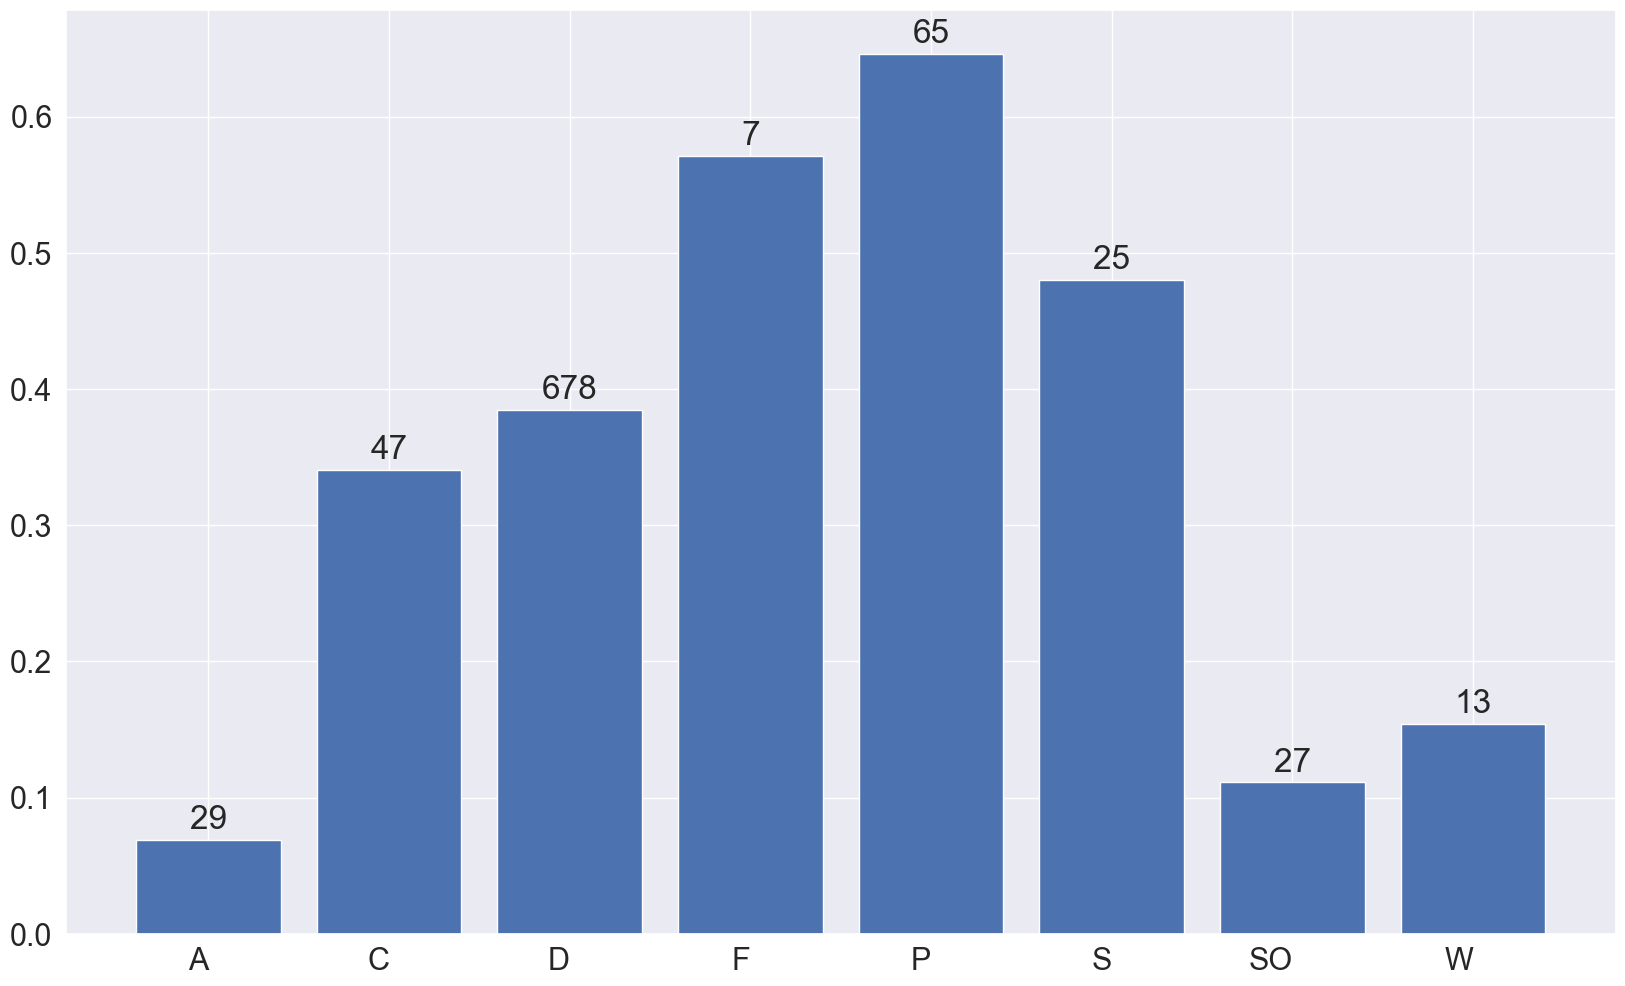

In [21]:
fig, ax = plt.subplots()
bars = ax.bar(df_investigacion1['PreTicket'], df_investigacion1['Survivedmean'])

for bar,count in zip(bars.patches, df_investigacion1.Survivedcount):
    
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better readability
        textcoords='offset points',
        ha='center', va='bottom')
 
ax.set_xticklabels(df_investigacion1['PreTicket'], rotation=360, ha='right')
 
# Finally showing the plot
plt.show()

### Me gusta esta distribución, parece que la primera letra del pre-ticket dice mucho acerca de si la persona sobrevive o no. El problema vino con las S que tienen una distribución un tanto similar, al final me decanto por separar las entre S y SO.

### - Propuestas Nueva col a ser testeadas en cross validation:

### 1) % salvados con esa letra de preticket.

### 2) % salvados con esa letra de preticket. ponderado por observaciones presentes con ese PreTicket:
### [(count del preticket/total observaciones)/(salvados de ese preticket/no salvados de ese preticket)]
### Trae problemas al hacer demasiado más significante desconocido.

## Pensándolo bien no debe ser bueno crear una variable que sea combinación lineal de la objetivo, probablemente traiga problemas, será mejor ordenar las categorías con números de peor a mejor.

### - No sé si las operaciones de string están eliminando información importante.

### En el pipeline final se intentará con algunas, con todas y sin operaciones, la que tenga mejor score en validación cruzada se quedará.

In [22]:
df_investigacion1["Survived_Ponderado"] = (df_investigacion1.Survivedcount/df_titanic.shape[0])*df_investigacion1.Survivedmean
#Propuesta1 = df_investigacion1[["PreTicket","Survivedmean"]]
#Propuesta2 = df_investigacion1[["PreTicket","Survived_Ponderado"]]
def asignarango(tick):
    if tick == "A":
        return 1
    elif tick == "SO":
        return 2
    elif tick == "W":
        return 3
    elif tick == "C":
        return 4
    elif tick == "D":
        return 5
    elif tick == "S":
        return 6
    elif tick == "F":
        return 7
    elif tick == "P":
        return 8

df_investigacion1["Ticket_Rank"] = df_investigacion1.PreTicket.apply(lambda x: asignarango(x))
df_investigacion1.sort_values(by = "Survivedmean")

,PreTicket,Survivedmean,Survivedcount,Survived_Ponderado,Ticket_Rank
0,A,0.068966,29,0.002245,1
6,SO,0.111111,27,0.003367,2
7,W,0.153846,13,0.002245,3
1,C,0.340426,47,0.017957,4
2,D,0.384956,678,0.292929,5
5,S,0.480000,25,0.013468,6
3,F,0.571429,7,0.004489,7
4,P,0.646154,65,0.047138,8


In [23]:
def metrica_preticket(Ticket, df, metrica):
    return df.loc[df["PreTicket"] == Ticket,metrica].values[0]

df_titanic["Porcentaje_PreTicket"] = df_titanic.PreTicket.apply(lambda x: metrica_preticket(x,df_investigacion1,"Survivedmean"))
df_titanic["PorcentajePonderado_PreTicket"] = df_titanic.PreTicket.apply(lambda x: metrica_preticket(x,df_investigacion1,"Survived_Ponderado"))
df_titanic["Ticket_Rank"] = df_titanic.PreTicket.apply(lambda x: metrica_preticket(x,df_investigacion1,"Ticket_Rank"))


cramer1 = NuestrasFunciones.cramers_v(df_titanic.Porcentaje_PreTicket,df_titanic.Survived)
cramer2 = NuestrasFunciones.cramers_v(df_titanic.PorcentajePonderado_PreTicket,df_titanic.Survived)
cramer3 = NuestrasFunciones.cramers_v(df_titanic.Ticket_Rank,df_titanic.Survived)

print(f"La variable sin ponderar tiene un valor de V de Cramer con la objetivo de: {cramer1}")
print(f"La variable ponderada tiene un lamentable valor de V de Cramer con la objetivo de: {cramer2}")
print(f"La variable con el rank tiene un valor de V de Cramer con la objetivo de: {cramer3}")

df_titanic.drop(["PorcentajePonderado_PreTicket","Porcentaje_PreTicket"], axis = 1,inplace = True)



La variable sin ponderar tiene un valor de V de Cramer con la objetivo de: 0.22236231686576632
La variable ponderada tiene un lamentable valor de V de Cramer con la objetivo de: 0.004099207464745925
La variable con el rank tiene un valor de V de Cramer con la objetivo de: 0.2228310717362426


## Al final nos evitamos problemas estadísticos y mejoramos la V de Cramer utilizando el rango del ticket en vez de una combinación lineal con la objetivo.

# Qué hacer con Name?

### Inspiración para hacer el dataset fueron profesores.

### Recuerdo que uno dijo que los apellidos funcionaban para ver idioma que habla el sujeto. Pero revisemos qué más se puede sacar de ellos.

In [24]:
#Algunos nombres tienen otro nombre entre paréntesis, hagamos búsqueda.
# ej: Cumings, Mrs. John Bradley (Florence Briggs Thayer)
j = 0
for i in df_titanic.Name:
    j += 1
    if "Borland" in i: 
        print(i,j)
    

print(df_titanic.Ticket[551],df_titanic.Ticket[582],df_titanic.Ticket[699])
print("--------------------------------")
z = 0
for i in df_titanic.Name:
    z += 1
    if "Bourke" in i: 
        print(i,z)
        

print(df_titanic.Ticket[189],df_titanic.Ticket[594],df_titanic.Ticket[658])

Thayer, Mr. John Borland Jr 551
Thayer, Mrs. John Borland (Marian Longstreth Morris) 582
Thayer, Mr. John Borland 699
244358 28403 348121
--------------------------------
Bourke, Mr. John 189
Bourke, Miss. Mary 594
Bourke, Mrs. John (Catherine) 658
349247 SCAH 29037 29751


#### Los nombres entre paréntesis parecen estar presentes únicamente en las Mrs, pero no siempre se encuentran sus esposos en la serie de nombres, es posible que viajen solas o que mi conclusión sea errónea.

#### Estos vienen definitivamente juntos y no tienen el mismo ticket number, mismo apellido nos dará buena info.

In [26]:
#Creo columna apellido que no será útil en el modelo final, pero si para este análisis
x = df_titanic.Name.apply(lambda x: x.split(","))
df_titanic["Apellido"] = df_titanic.Name.apply(lambda x: x.split(",")[0])

#### Cantidad mismo apellido es: <frecuencia de tu apellido -1> Porque se define como cantidad de personas con mismo apellido que tú excluyendo al analizado.

In [27]:
def mismo_apellido(ape, ser):
    valores = ser.value_counts()
    return valores[ape] - 1

df_titanic["Cantidad_MismoApellido"] = df_titanic["Apellido"].apply(lambda x: mismo_apellido(x,df_titanic.Apellido))
cramer = NuestrasFunciones.cramers_v(df_titanic["Cantidad_MismoApellido"],df_titanic["Survived"])
print(f"La variable cantidad de personas con tu mismo apellido tiene un valor de V de Cramer con la objetivo de: {cramer}")

La variable cantidad de personas con tu mismo apellido tiene un valor de V de Cramer con la objetivo de: 0.10948632209863142


In [53]:
w = 0
for i in df_titanic.Name:
    w += 1
    if "Mrs" in i:
        if df_titanic.SiblingsSpouses[w] == 0 and df_titanic.ParentsChildren[w] == 0:
            #print(i)
            #print("--------------------------------")
            pass

#Hay una lady y una contesa

In [54]:
df_titanic["Titulo"] = df_titanic.Name.apply(lambda x: x.split(",")[1].split(".")[0].replace(" ",""))
df_titanic["Titulo"].value_counts()

Mr             517
Miss           182
Mrs            125
Master          40
Dr               7
Rev              6
Mlle             2
Major            2
Col              2
theCountess      1
Capt             1
Ms               1
Sir              1
Lady             1
Mme              1
Don              1
Jonkheer         1
Name: Titulo, dtype: int64

In [55]:
df_investigacion2 = df_titanic[["Titulo","Survived"]]

df_investigacion2 = df_investigacion2.groupby(["Titulo"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
df_investigacion2.columns = list(map("".join, df_investigacion2.columns.values))
df_investigacion2.reset_index(inplace = True)
#df_investigacion2

/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_1417/2732409440.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_investigacion2['Titulo'], rotation=90, ha='right')


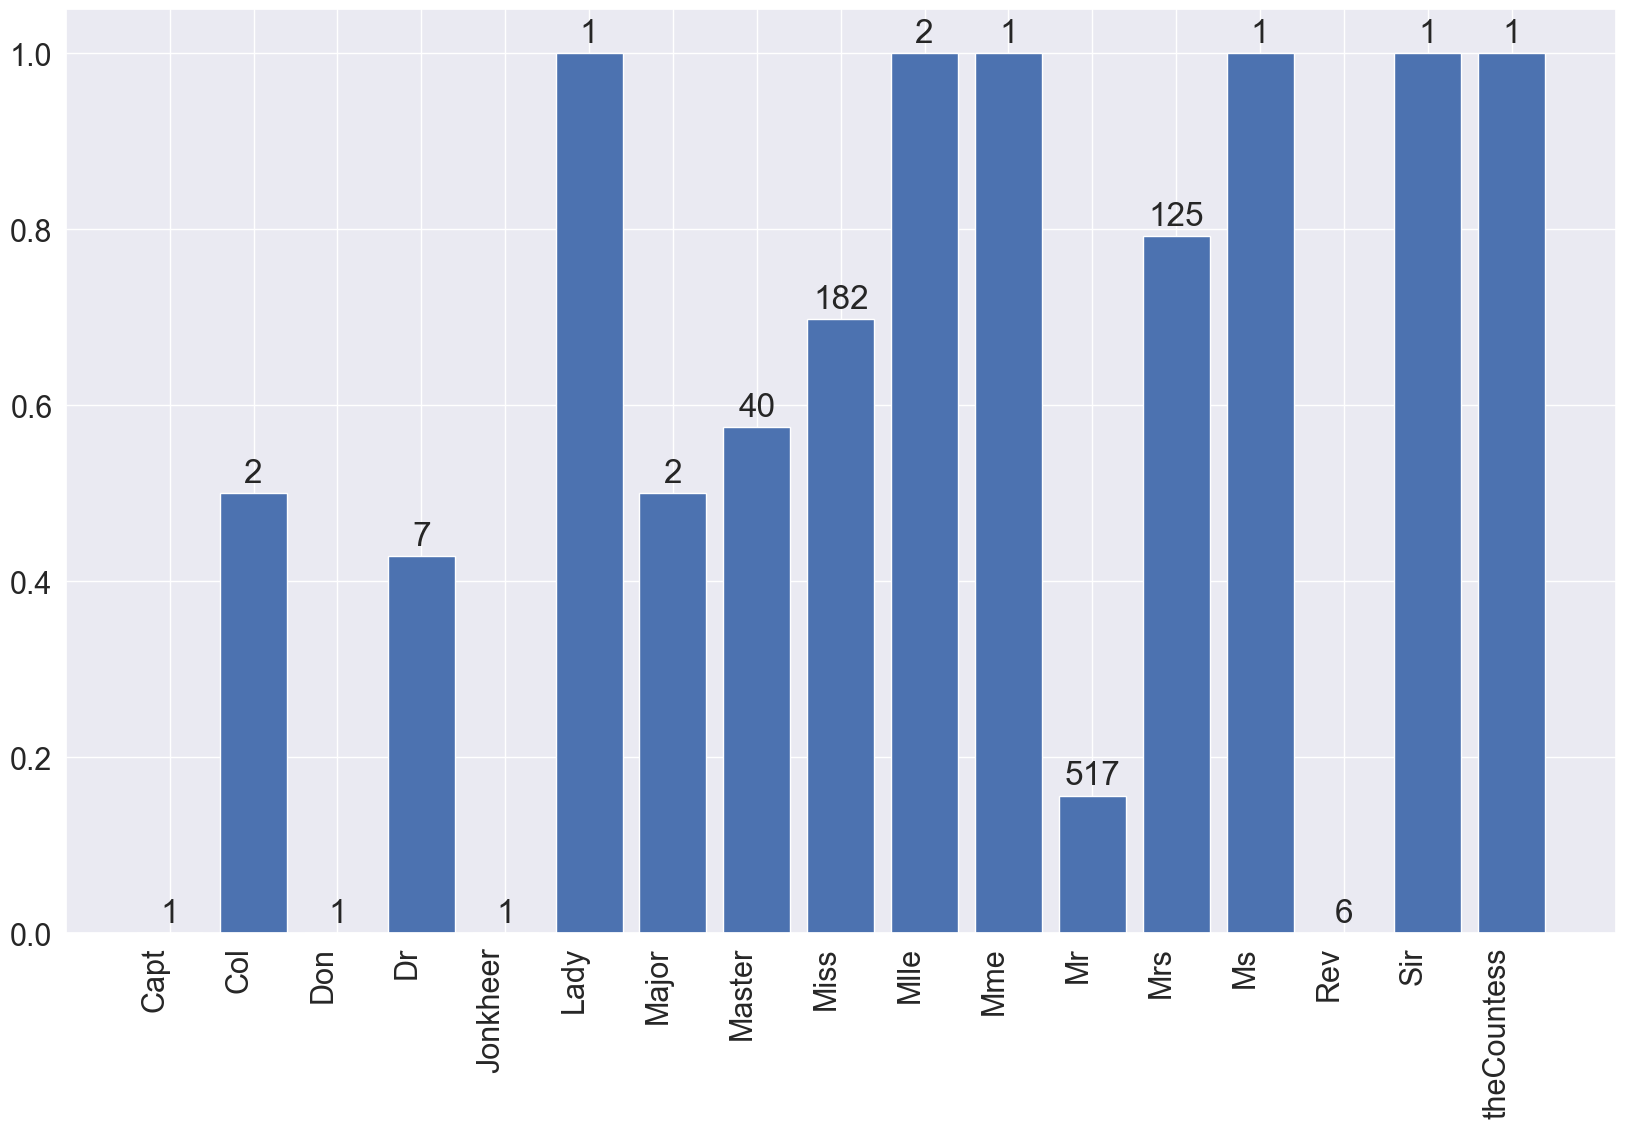

In [56]:
fig, ax = plt.subplots()
bars = ax.bar(df_investigacion2['Titulo'], df_investigacion2['Survivedmean'])

for bar,count in zip(bars.patches, df_investigacion2.Survivedcount):
    
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better readability
        textcoords='offset points',
        ha='center', va='bottom')
 
ax.set_xticklabels(df_investigacion2['Titulo'], rotation=90, ha='right')
 
# Finally showing the plot
plt.show()

In [57]:
df_titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SiblingsSpouses', 'ParentsChildren', 'Ticket', 'Fare', 'Cabin',
       'Embarked', 'PostTicket', 'Cant_PersonasMismoTicket', 'PreTicket',
       'Ticket_Rank', 'Apellido', 'Cantidad_MismoApellido', 'Titulo'],
      dtype='object')

#### Tip de profesor invitado de Vodafone: los Reverendos se sacrifican por los demás.

#### Las Miss son probablemente hijas o mistresses.

<Axes: >

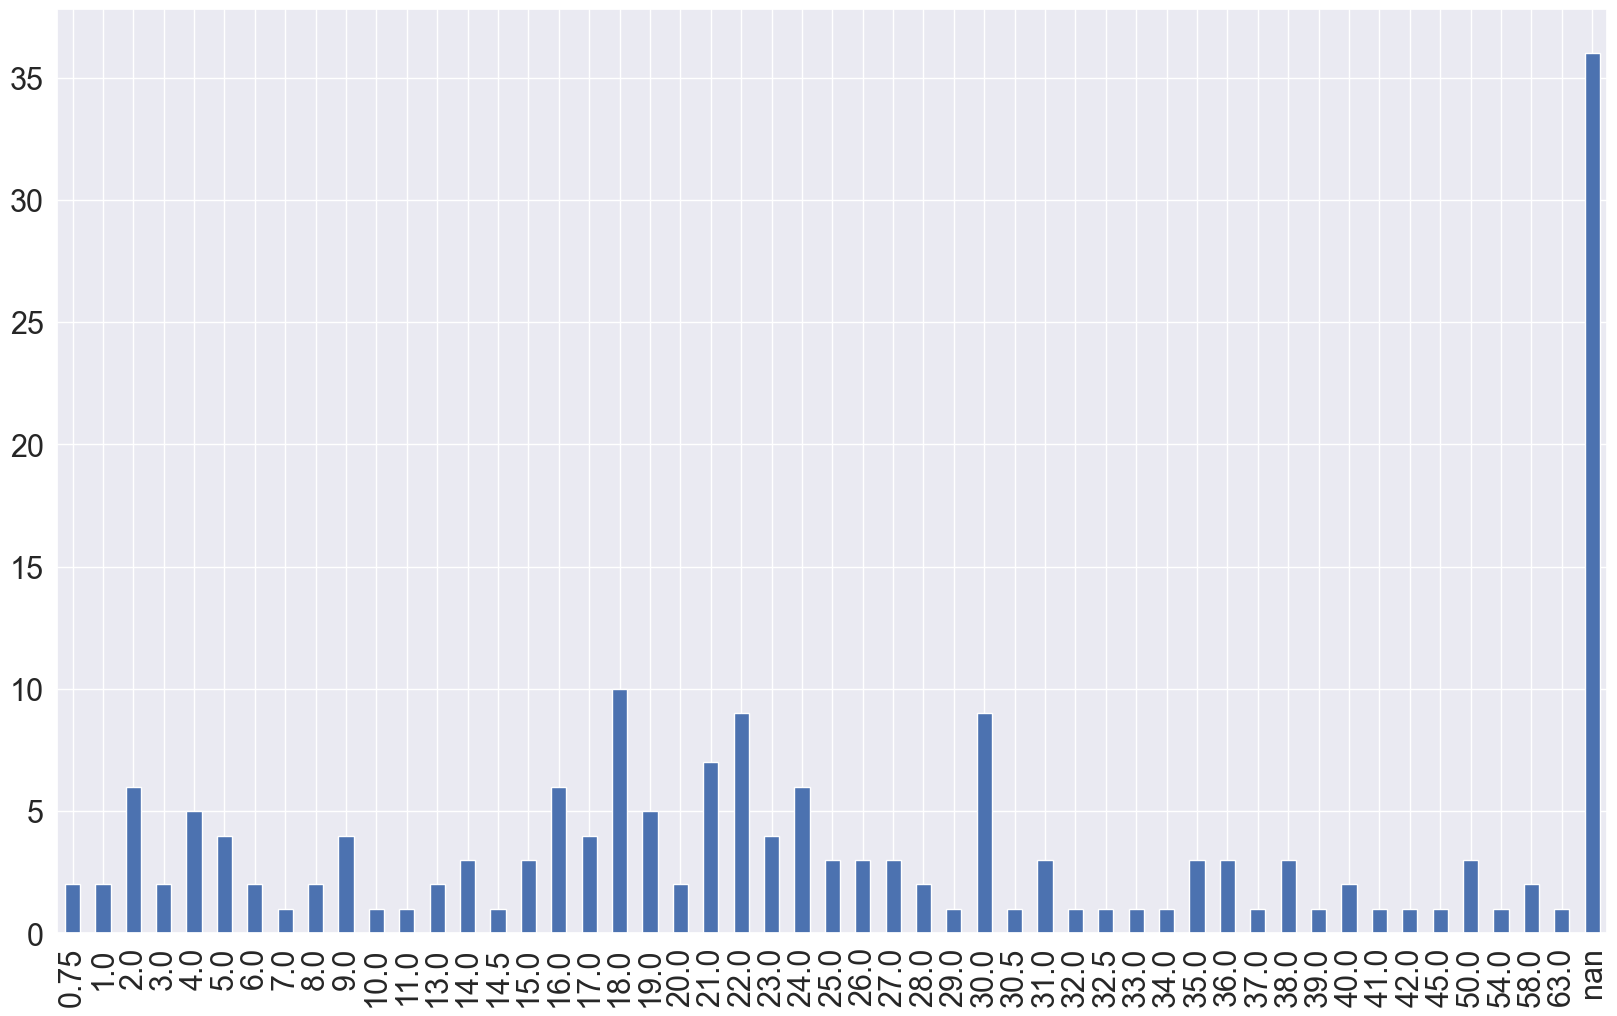

In [59]:
df_investigacion2 = df_titanic[["Titulo","Age","SiblingsSpouses","ParentsChildren"]]
df_investigacion2 = df_investigacion2.loc[df_investigacion2["Titulo"] == "Miss"]
df_investigacion2.Age.value_counts(dropna = False).sort_index().plot.bar()

#### Demasiados Nas (cuya distribución desconocemos), como para hacer un análisis fidedigno de esta manera.

# A continuación disgregaremos a los títulos más importantes en grupos que diferencien su survival rate

#### De las mejores cualidades de la ciencia de datos es su carácter iterativo. Esta sección la he hecho y rehecho muchas veces.

#### Dodge, Master. Washington tiene 2 ParentsChildren, pero 0 personas con el mismo apellido, revisé incluso el algoritmo que genera Cantidad_MismoApellido, pero está bien, es muy raro.

#### Thomas, Master. Assad Alexander tiene 1 ParentsChildren, pero 0 personas con el mismo apellido, revisé incluso el algoritmo que genera Cantidad_MismoApellido, pero está bien, es muy raro.

In [60]:
z = 0
for i in df_titanic.Name:
    if "Dodge" in i: 
        print(i,z)
        print(f"cantidad de ParentChildren: {df_titanic.iloc[z].ParentsChildren}")
        print(f"cantidad mismo apellido: {df_titanic.iloc[z].Cantidad_MismoApellido}")
        print(f"Age: {df_titanic.iloc[z].Age}")
    z +=1
print("--------------------------------")
z = 0
for i in df_titanic.Apellido:
    if "Thomas" in i: 
        print(i)
        print(f"cantidad de ParentChildren: {df_titanic.iloc[z].ParentsChildren}")
        print(f"cantidad mismo apellido: {df_titanic.iloc[z].Cantidad_MismoApellido}")
        print(f"Age: {df_titanic.iloc[z].Age}")
    z += 1
print()
print("Según las instrucciones ParentsChild sólo toma como parents a mother y father, no a stepmothers, stepfathers o nannies. Es extraño.")

Dodge, Master. Washington 445
cantidad de ParentChildren: 2
cantidad mismo apellido: 0
Age: 4.0
--------------------------------
Thomas
cantidad de ParentChildren: 1
cantidad mismo apellido: 0
Age: 0.42

Según las instrucciones ParentsChild sólo toma como parents a mother y father, no a stepmothers, stepfathers o nannies. Es extraño.


(182, 6)


/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_1417/61504522.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_barras2['Titulo'], rotation=90, ha='right')


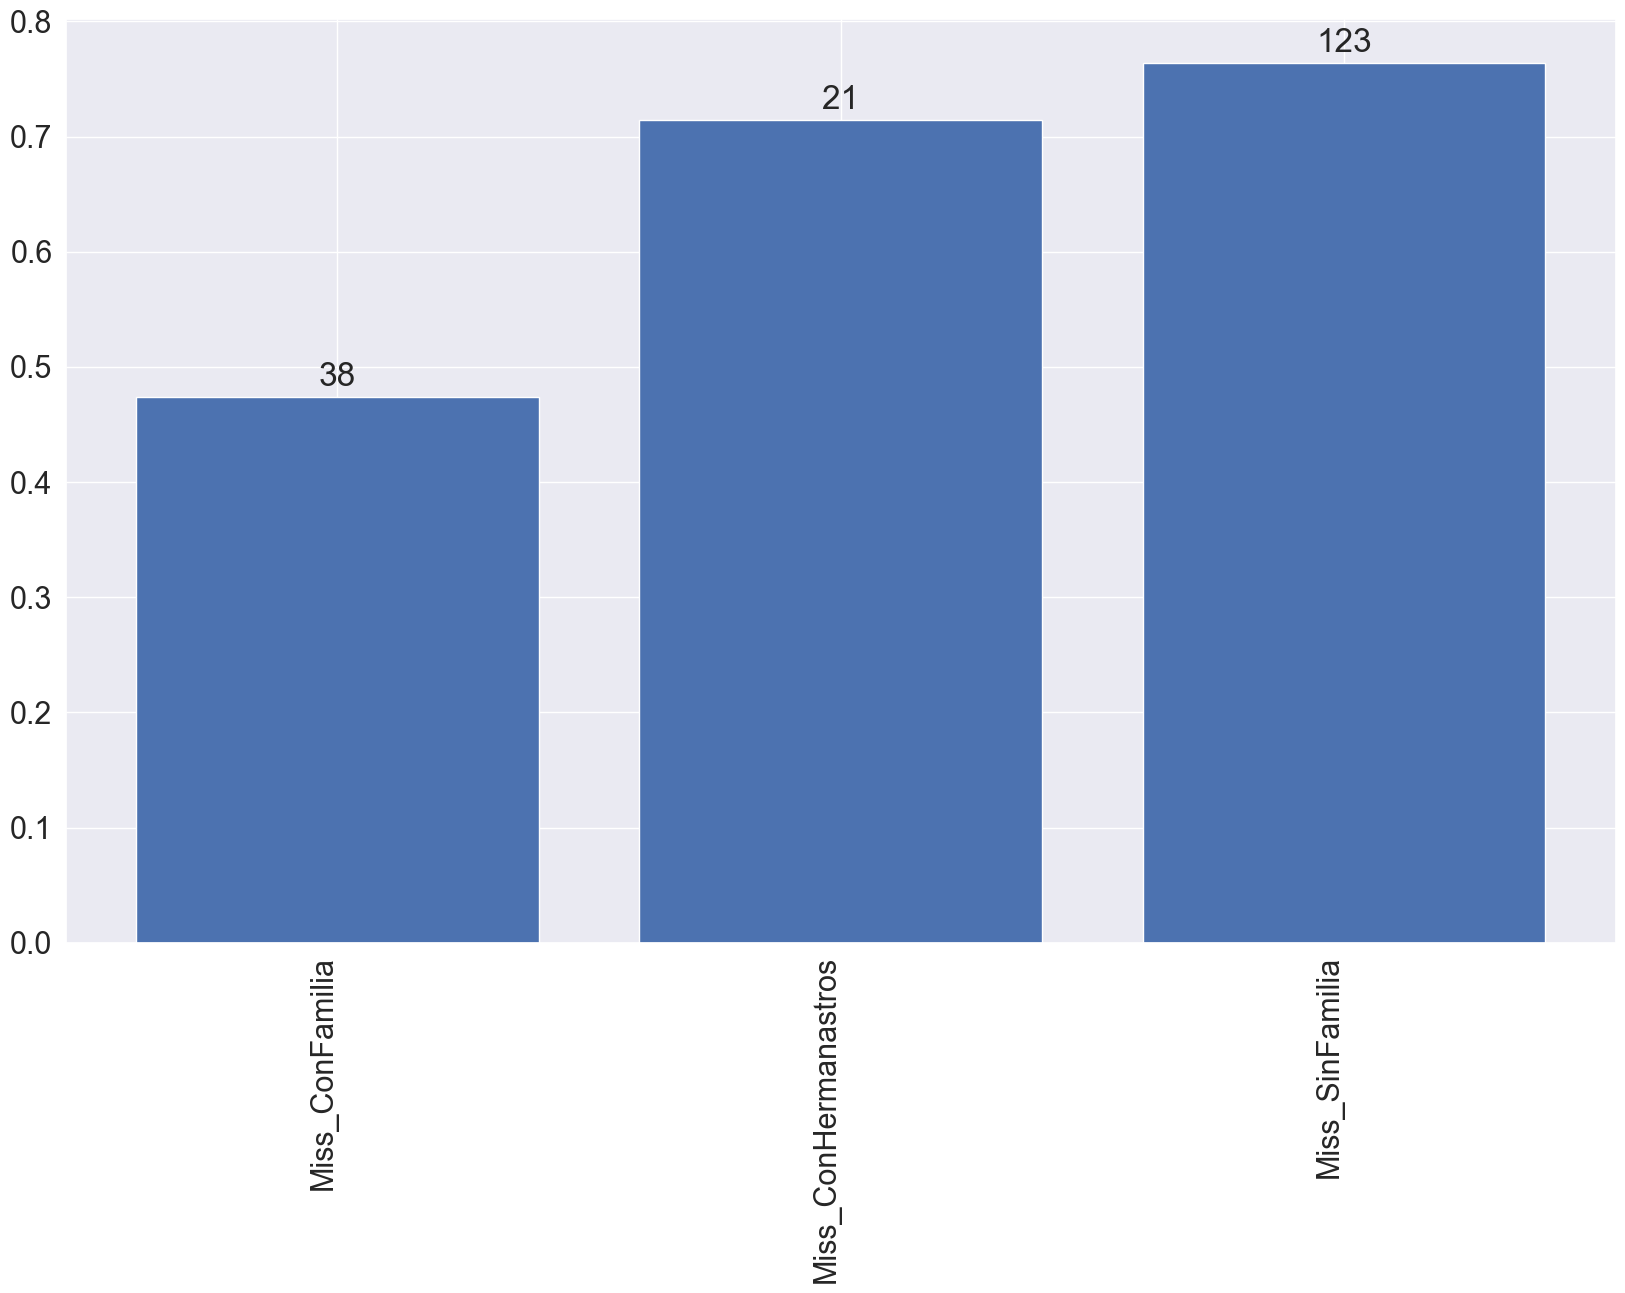

In [61]:
df_investigacion2 = df_titanic[["Titulo","Age","SiblingsSpouses","ParentsChildren","Cantidad_MismoApellido","Survived"]]
df_investigacion2 = df_investigacion2.loc[df_investigacion2["Titulo"] == "Miss"]
print(df_investigacion2.loc[df_investigacion2["Titulo"] == "Miss"].shape)
#Selección más robusta utilizando la misma técnica empleada porsteriormente al estudiar a los masters.
#Debería, en teoría dar los mismos resulatados Cantidad_MismoApellido == 0 y ParentsChildren == 0. Pero por alguna razón no es así
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] == 0) | (df_investigacion2["ParentsChildren"] == 0) | (df_investigacion2["SiblingsSpouses"] == 0)) & (df_investigacion2["Titulo"] == "Miss"),"Titulo"] = "Miss_SinFamilia"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] != 0) & (df_investigacion2["ParentsChildren"] != 0) & (df_investigacion2["SiblingsSpouses"] != 0)) & (df_investigacion2["Titulo"] == "Miss"),"Titulo"] = "Miss_ConFamilia"
df_investigacion2.loc[((df_investigacion2["SiblingsSpouses"] != 0)) & (df_investigacion2["Titulo"] == "Miss_SinFamilia"),"Titulo"] = "Miss_ConHermanastros"

#df_investigacion2.loc[(df_investigacion2["Cantidad_MismoApellido"] == 0) & (df_investigacion2["Titulo"] == "Miss"),"Titulo"] = "Miss_SinFamilia"
#df_investigacion2.loc[(df_investigacion2["Cantidad_MismoApellido"] != 0)  & (df_investigacion2["Titulo"] == "Miss"),"Titulo"] = "Miss_ConFamilia"


df_barras2 = df_investigacion2.groupby(["Titulo"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
df_barras2.columns = list(map("".join, df_barras2.columns.values))
df_barras2.reset_index(inplace = True)

fig, ax = plt.subplots()
bars = ax.bar(df_barras2['Titulo'], df_barras2['Survivedmean'])

for bar,count in zip(bars.patches, df_barras2.Survivedcount):
    
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better readability
        textcoords='offset points',
        ha='center', va='bottom')
 
ax.set_xticklabels(df_barras2['Titulo'], rotation=90, ha='right')
 
# Finally showing the plot
plt.show()


(182, 7)


/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_1417/3723182153.py:21: FutureWarning: ['Name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_barras2 = df_investigacion2.groupby(["Titulo"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_1417/3723182153.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_barras2['Titulo'], rotation=90, ha='right')


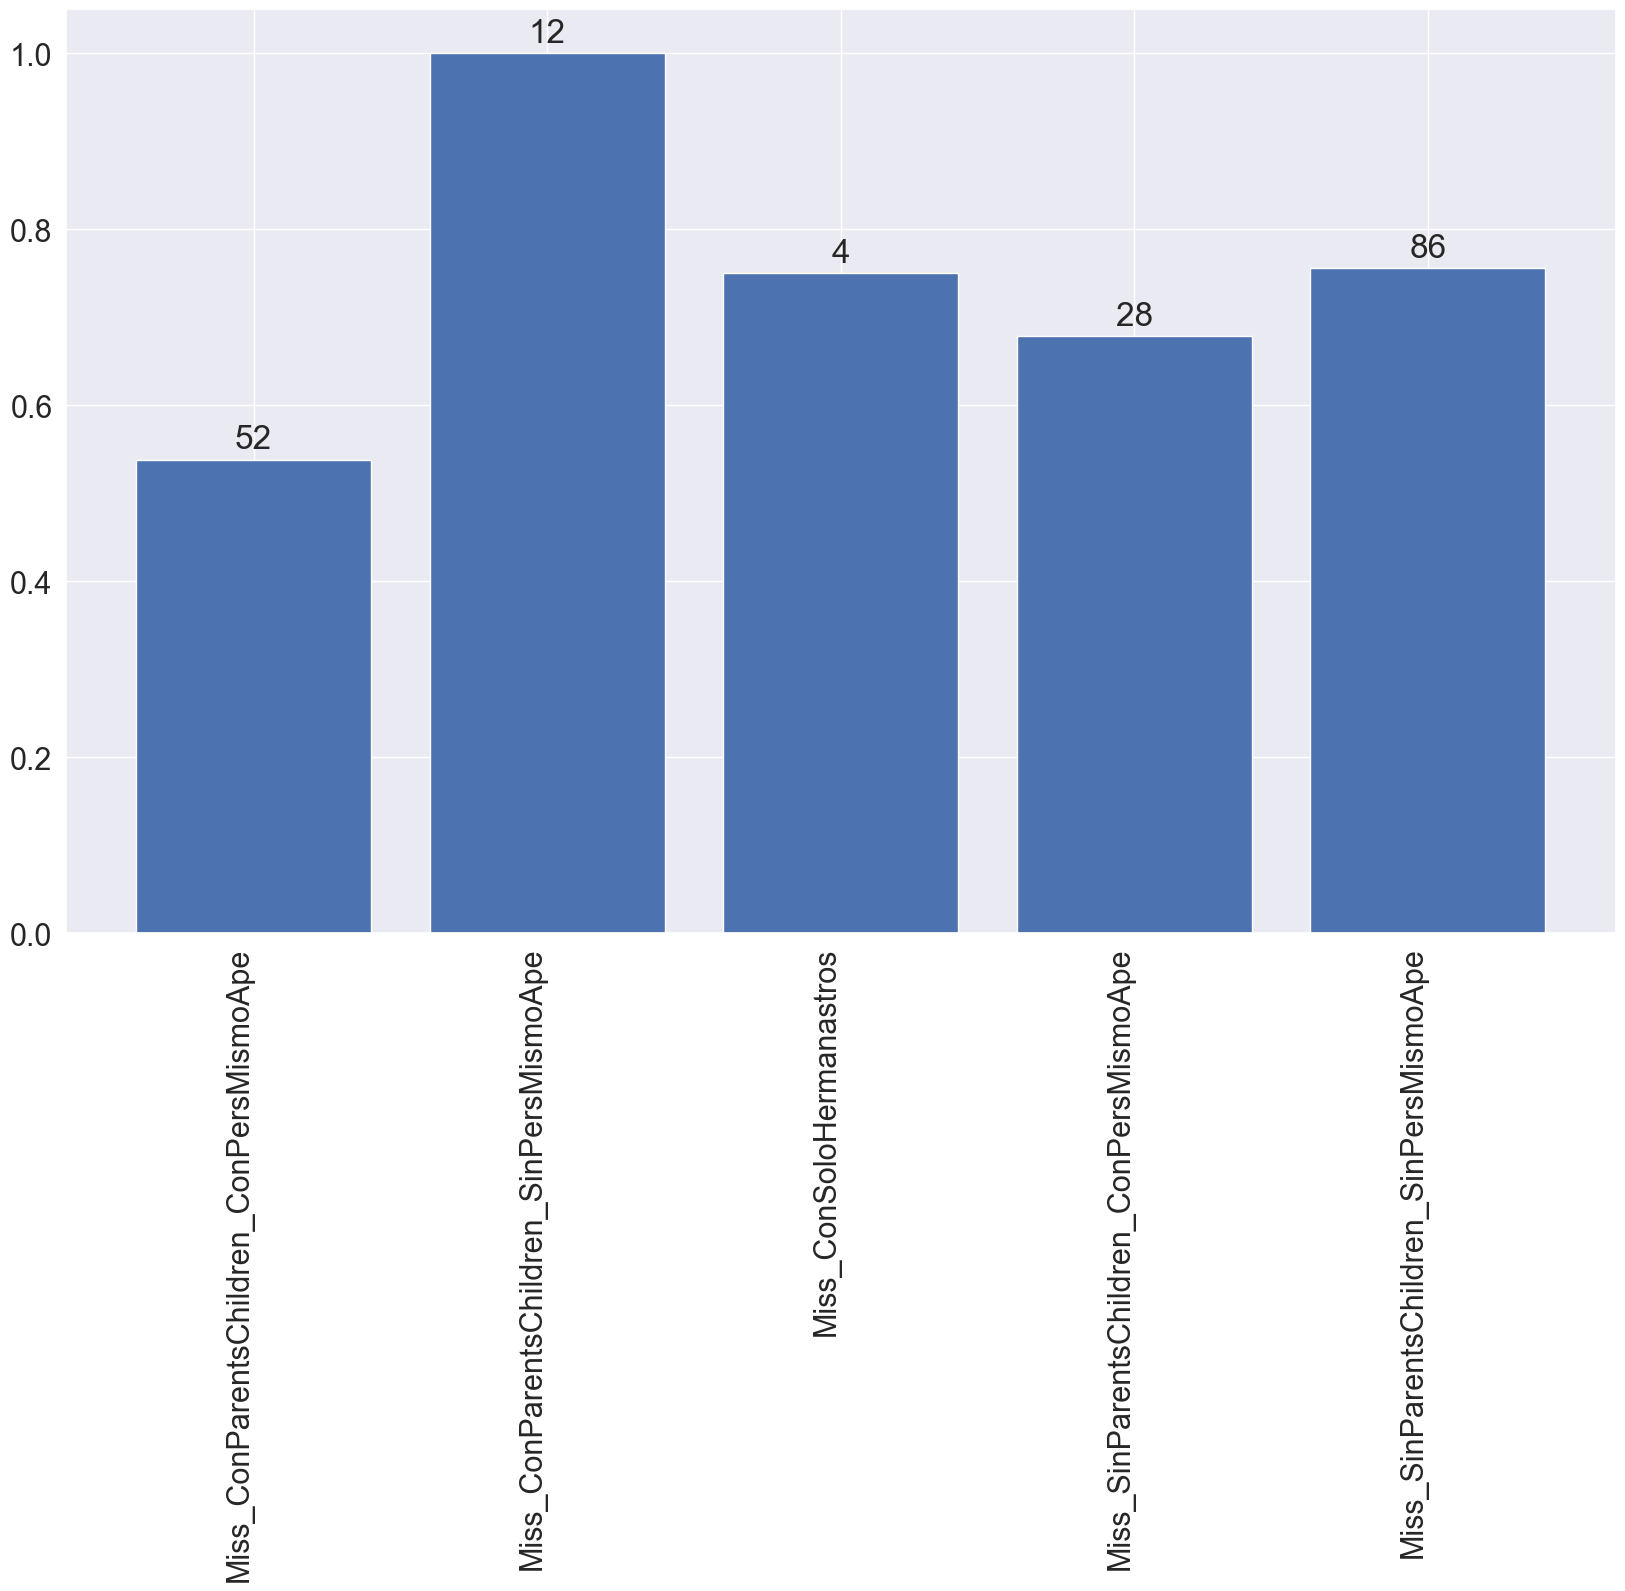

In [62]:
df_investigacion2 = df_titanic[["Titulo","Age","SiblingsSpouses","ParentsChildren","Cantidad_MismoApellido","Survived","Name"]]
print(df_investigacion2.loc[df_investigacion2["Titulo"] == "Miss"].shape)
df_investigacion2 = df_investigacion2.loc[df_investigacion2["Titulo"] == "Miss"]

#Selección muy robusta tipo arbol de decisión.
df_investigacion2.loc[((df_investigacion2["ParentsChildren"] == 0) & (df_investigacion2["Titulo"] == "Miss")),"Titulo"] = "Miss_SinParentsChildren"
df_investigacion2.loc[((df_investigacion2["ParentsChildren"] != 0) & (df_investigacion2["Titulo"] == "Miss")),"Titulo"] = "Miss_ConParentsChildren"


df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] == 0) & (df_investigacion2["Titulo"] == "Miss_SinParentsChildren")),"Titulo"] = "Miss_SinParentsChildren_SinPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] != 0) & (df_investigacion2["Titulo"] == "Miss_SinParentsChildren")),"Titulo"] = "Miss_SinParentsChildren_ConPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] == 0) & (df_investigacion2["Titulo"] == "Miss_ConParentsChildren")),"Titulo"] = "Miss_ConParentsChildren_SinPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] != 0) & (df_investigacion2["Titulo"] == "Miss_ConParentsChildren")),"Titulo"] = "Miss_ConParentsChildren_ConPersMismoApe"


df_investigacion2.loc[((df_investigacion2["SiblingsSpouses"] != 0) & (df_investigacion2["Titulo"] == "Miss_SinParentsChildren_SinPersMismoApe")),"Titulo"] = "Miss_ConSoloHermanastros"
df_Miss = df_investigacion2.copy()
#df_investigacion2.loc[(df_investigacion2["Cantidad_MismoApellido"] == 0) & (df_investigacion2["Titulo"] == "Miss"),"Titulo"] = "Miss_SinFamilia"
#df_investigacion2.loc[(df_investigacion2["Cantidad_MismoApellido"] != 0)  & (df_investigacion2["Titulo"] == "Miss"),"Titulo"] = "Miss_ConFamilia"
df_barras2 = df_investigacion2.loc[df_investigacion2["Titulo"] == "Miss"]
df_barras2 = df_investigacion2.groupby(["Titulo"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
df_barras2.columns = list(map("".join, df_barras2.columns.values))
df_barras2.reset_index(inplace = True)
df_Miss_agg = df_investigacion2.copy()


fig, ax = plt.subplots()
bars = ax.bar(df_barras2['Titulo'], df_barras2['Survivedmean'])

for bar,count in zip(bars.patches, df_barras2.Survivedcount):
    
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better readability
        textcoords='offset points',
        ha='center', va='bottom')
 
ax.set_xticklabels(df_barras2['Titulo'], rotation=90, ha='right')
 
# Finally showing the plot
plt.show()


#### Estas sub-categorías ya nos dan mucha información en cuanto al survival rate, no dudo que más al acompañarla por age luego de librarnos de los missings.



#### La diferencia en Máster con o sin ParentsChildren debe ser abismal, en su caso ParentsChildren es necesariamente Parents.

#### Gracias Wikipedia! "Master is an English honorific for boys and young men" ¿Pero por qué sobreviven tan poco si women and children first?

(40, 6)


/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_1417/2569317944.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_barras2['Titulo'], rotation=90, ha='right')


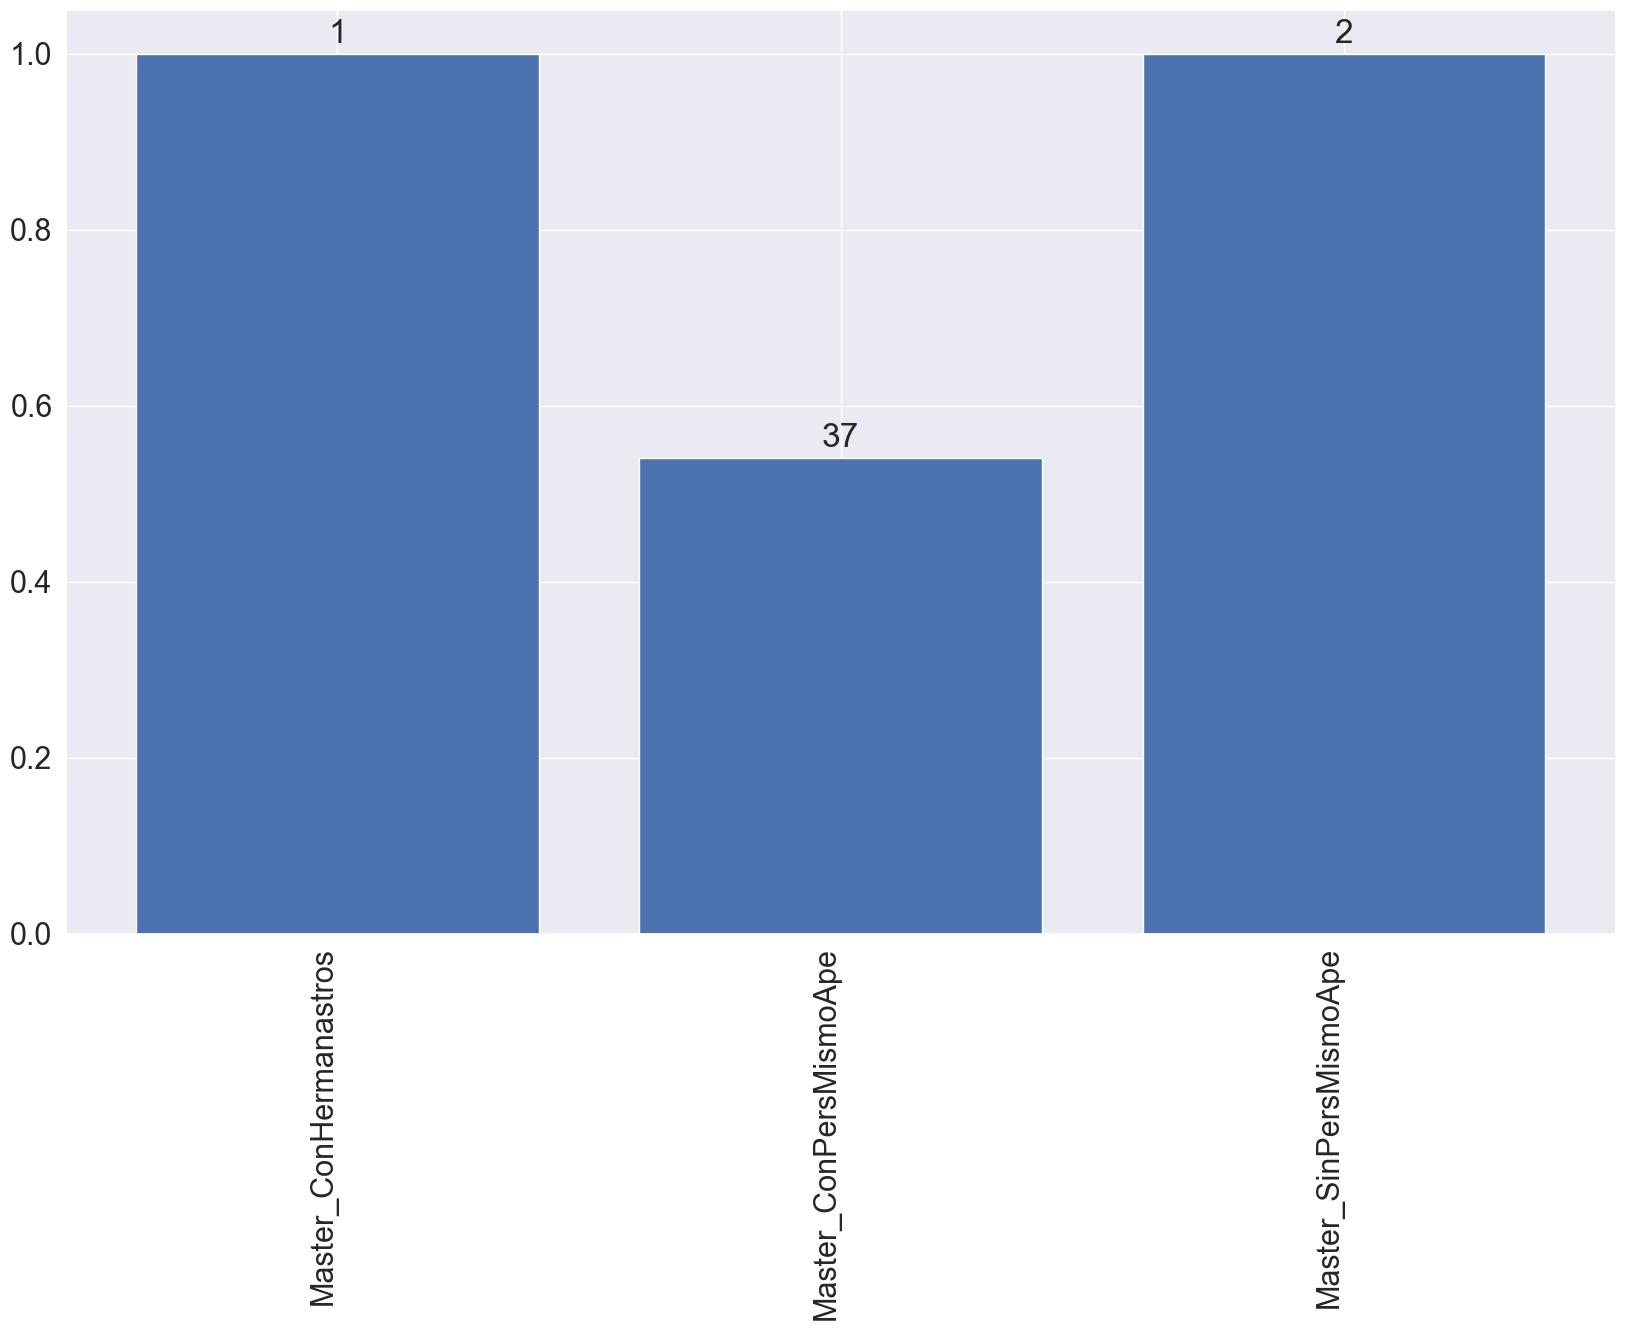

In [63]:
df_investigacion2 = df_titanic[["Titulo","Age","SiblingsSpouses","ParentsChildren","Cantidad_MismoApellido","Survived"]]

print(df_investigacion2.loc[df_investigacion2["Titulo"] == "Master"].shape)
df_investigacion2 = df_investigacion2.loc[df_investigacion2["Titulo"] == "Master"]


df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] == 0) | (df_investigacion2["ParentsChildren"] == 0)) & (df_investigacion2["Titulo"] == "Master"),"Titulo"] = "Master_SinPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] != 0) & (df_investigacion2["ParentsChildren"] != 0))  & (df_investigacion2["Titulo"] == "Master"),"Titulo"] = "Master_ConPersMismoApe"
df_investigacion2.loc[(df_investigacion2["SiblingsSpouses"] != 0) & (df_investigacion2["Titulo"] == "Master_SinPersMismoApe"),"Titulo"] = "Master_ConHermanastros"

df_barras2 = df_investigacion2.groupby(["Titulo"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
df_barras2.columns = list(map("".join, df_barras2.columns.values))
df_barras2.reset_index(inplace = True)


fig, ax = plt.subplots()
bars = ax.bar(df_barras2['Titulo'], df_barras2['Survivedmean'])

for bar,count in zip(bars.patches, df_barras2.Survivedcount):
    
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better readability
        textcoords='offset points',
        ha='center', va='bottom')
 
ax.set_xticklabels(df_barras2['Titulo'], rotation=90, ha='right')



# Finally showing the plot
plt.show()


(40, 7)


/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_1417/2661557473.py:21: FutureWarning: ['Name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_barras2 = df_investigacion2.groupby(["Titulo"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_1417/2661557473.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_barras2['Titulo'], rotation=90, ha='right')


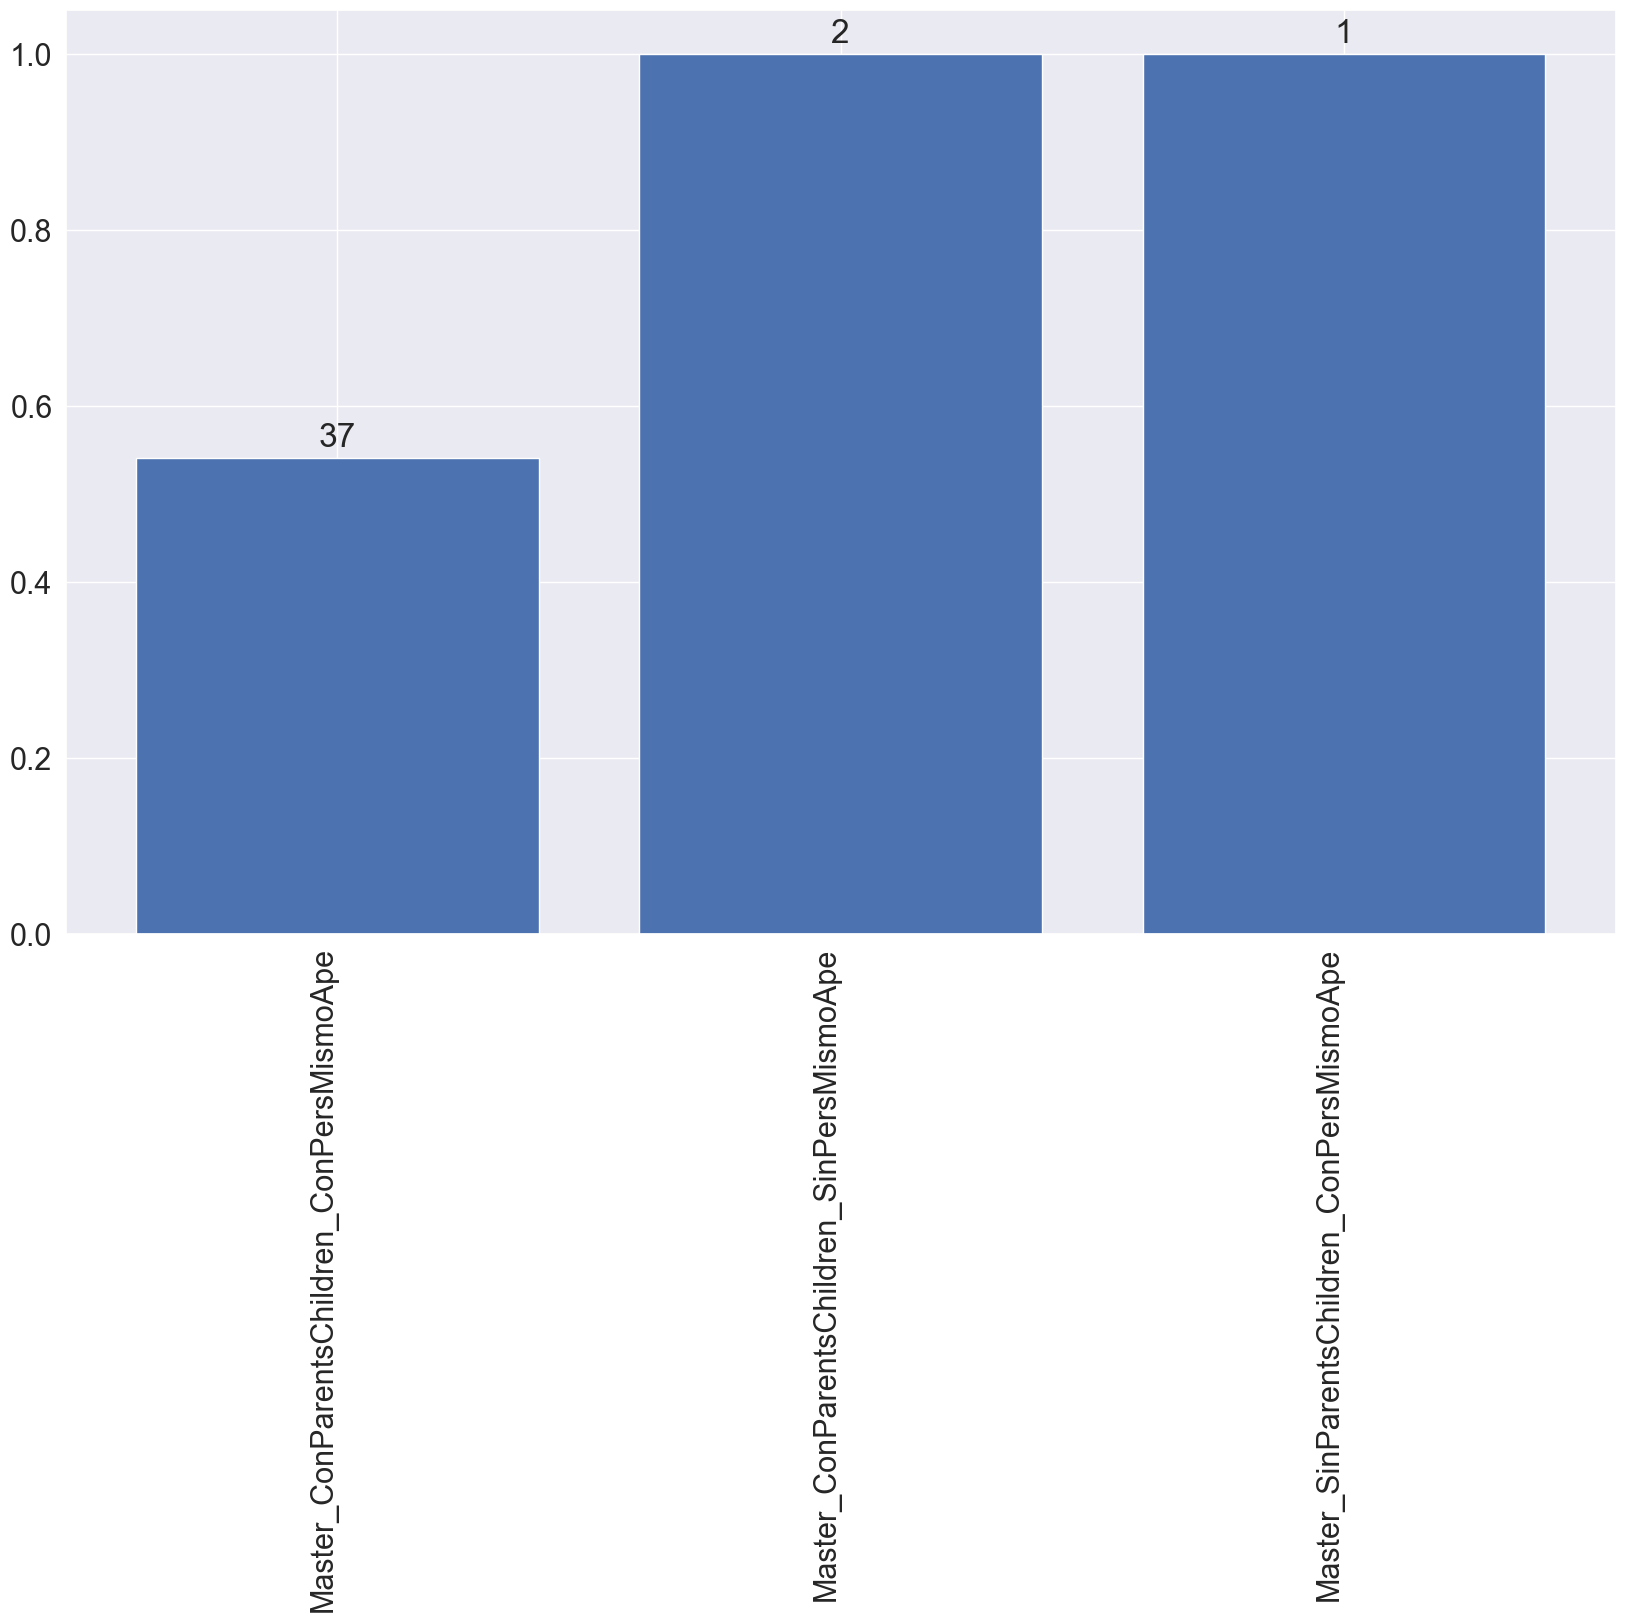

In [64]:
df_investigacion2 = df_titanic[["Titulo","Age","SiblingsSpouses","ParentsChildren","Cantidad_MismoApellido","Survived","Name"]]

print(df_investigacion2.loc[df_investigacion2["Titulo"] == "Master"].shape)
df_investigacion2 = df_investigacion2.loc[df_investigacion2["Titulo"] == "Master"]


df_investigacion2.loc[((df_investigacion2["ParentsChildren"] == 0) & (df_investigacion2["Titulo"] == "Master")),"Titulo"] = "Master_SinParentsChildren"
df_investigacion2.loc[((df_investigacion2["ParentsChildren"] != 0) & (df_investigacion2["Titulo"] == "Master")),"Titulo"] = "Master_ConParentsChildren"


df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] == 0) & (df_investigacion2["Titulo"] == "Master_SinParentsChildren")),"Titulo"] = "Master_SinParentsChildren_SinPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] != 0) & (df_investigacion2["Titulo"] == "Master_SinParentsChildren")),"Titulo"] = "Master_SinParentsChildren_ConPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] == 0) & (df_investigacion2["Titulo"] == "Master_ConParentsChildren")),"Titulo"] = "Master_ConParentsChildren_SinPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] != 0) & (df_investigacion2["Titulo"] == "Master_ConParentsChildren")),"Titulo"] = "Master_ConParentsChildren_ConPersMismoApe"


df_investigacion2.loc[((df_investigacion2["SiblingsSpouses"] != 0) & (df_investigacion2["Titulo"] == "Master_SinParentsChildren_SinFamilia")),"Titulo"] = "Master_ConSoloHermanastros"
df_Master = df_investigacion2.copy()


df_barras2 = df_investigacion2.groupby(["Titulo"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
df_barras2.columns = list(map("".join, df_barras2.columns.values))
df_barras2.reset_index(inplace = True)
df_Master_agg = df_barras2.copy()

fig, ax = plt.subplots()
bars = ax.bar(df_barras2['Titulo'], df_barras2['Survivedmean'])

for bar,count in zip(bars.patches, df_barras2.Survivedcount):
    
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better readability
        textcoords='offset points',
        ha='center', va='bottom')
 
ax.set_xticklabels(df_barras2['Titulo'], rotation=90, ha='right')
# Finally showing the plot
plt.show()




#### Por alguna razón los niños either sin personas con mismo apellido o sin parents children sobreviven al 100% (ojo con tamaño muestral de 3)

#### Master y Miss con familia tienen resultados similares. Cambia mucho al ser sin familia.

/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_1417/739530705.py:25: FutureWarning: ['Name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_barras2 = df_investigacion2.groupby(["Titulo"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_1417/739530705.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_barras2['Titulo'], rotation=90, ha='right')


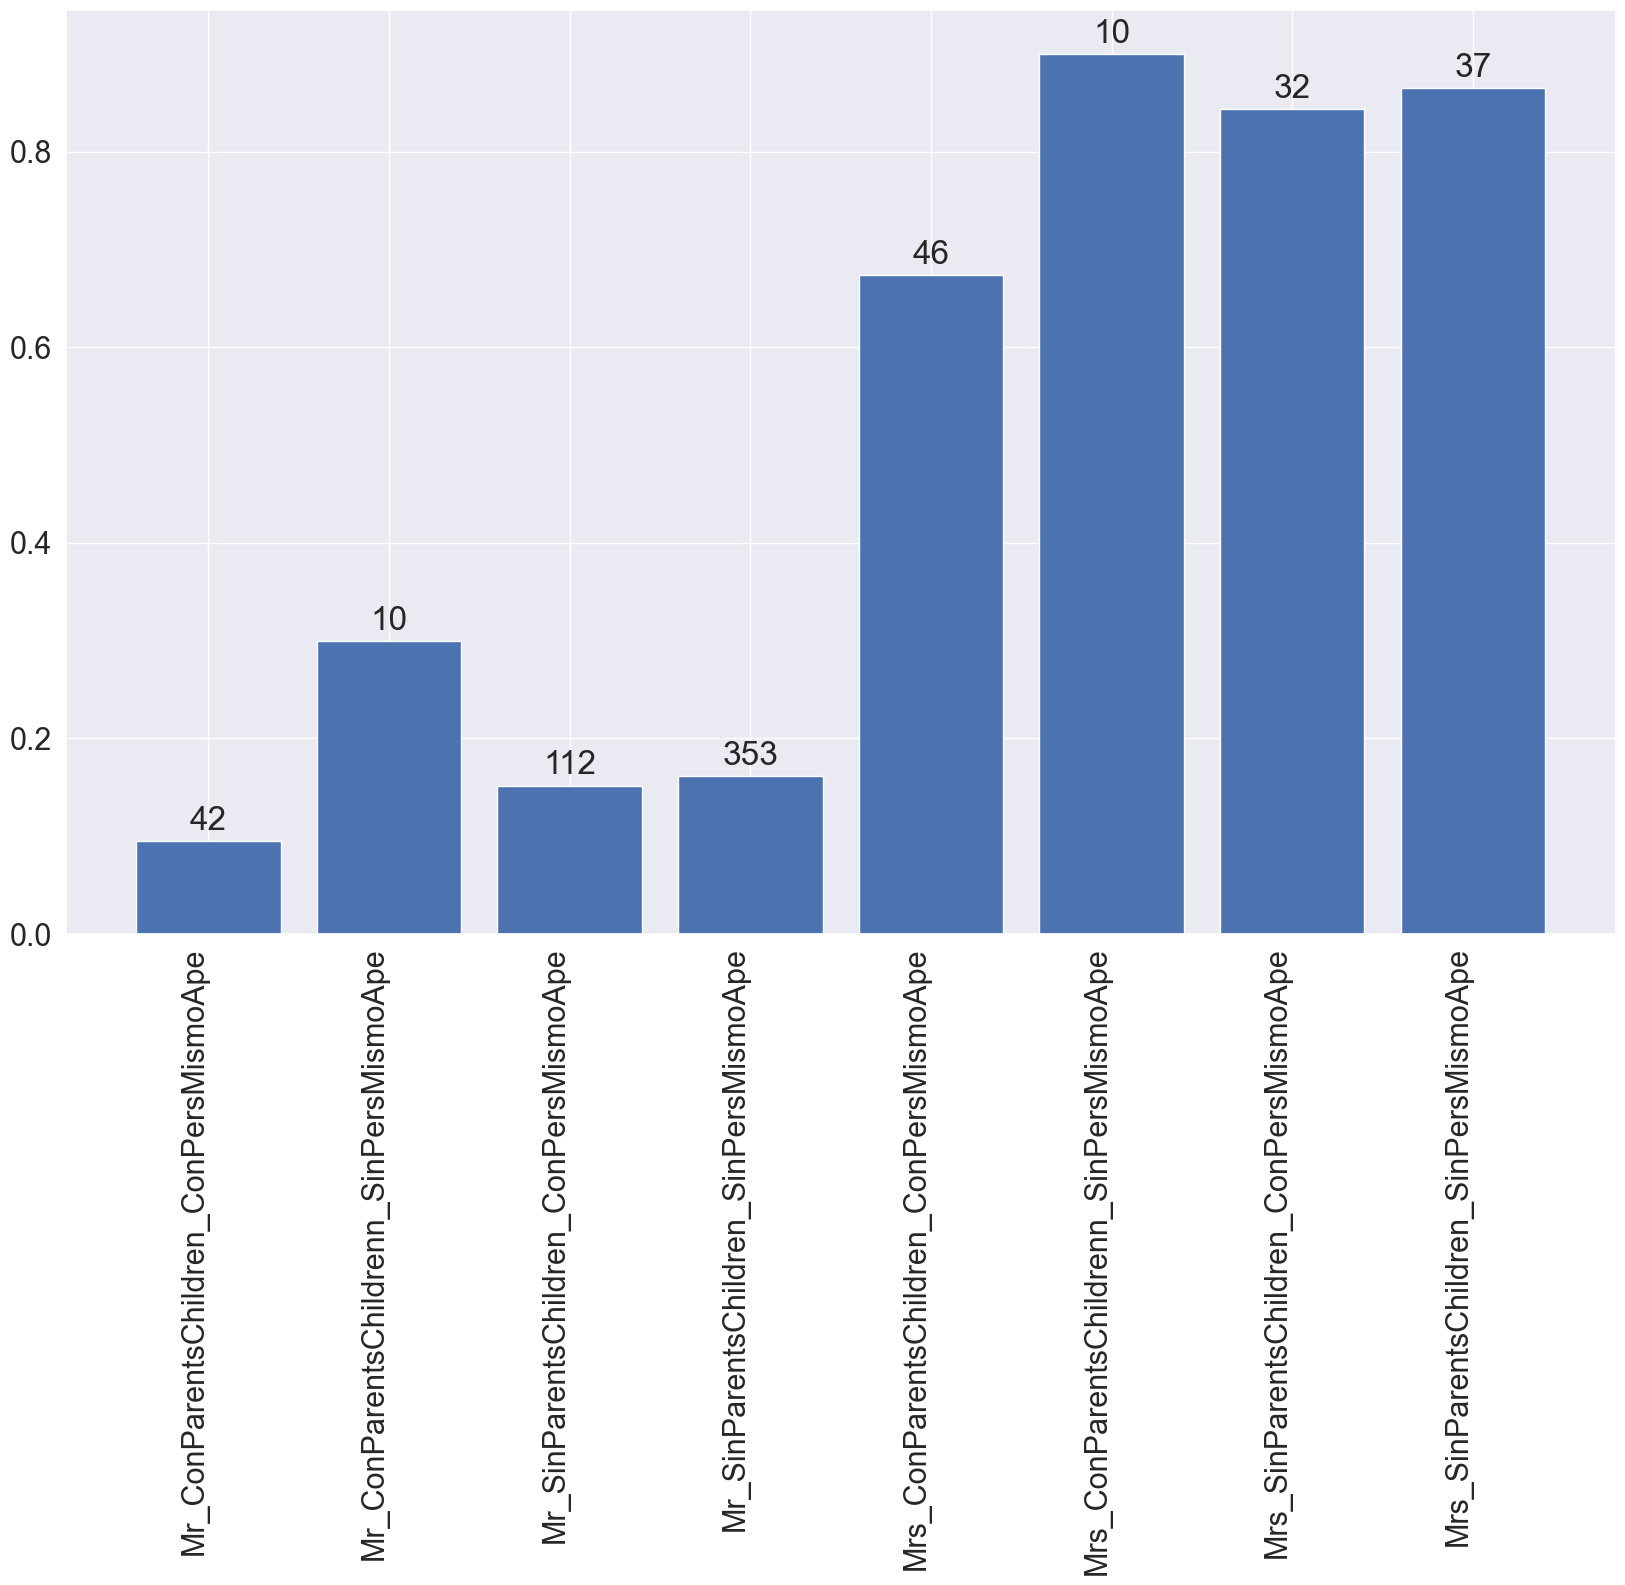

In [69]:
df_investigacion2 = df_titanic[["Titulo","Age","SiblingsSpouses","ParentsChildren","Cantidad_MismoApellido","Survived","Name"]]

df_investigacion2 = df_investigacion2.loc[(df_investigacion2["Titulo"] == "Mr") | (df_investigacion2["Titulo"] == "Mrs")]


df_investigacion2.loc[((df_investigacion2["ParentsChildren"] == 0) & (df_investigacion2["Titulo"] == "Mr")),"Titulo"] = "Mr_SinParentsChildren"
df_investigacion2.loc[((df_investigacion2["ParentsChildren"] != 0) & (df_investigacion2["Titulo"] == "Mr")),"Titulo"] = "Mr_ConParentsChildren"

df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] == 0) & (df_investigacion2["Titulo"] == "Mr_SinParentsChildren")),"Titulo"] = "Mr_SinParentsChildren_SinPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] != 0) & (df_investigacion2["Titulo"] == "Mr_SinParentsChildren")),"Titulo"] = "Mr_SinParentsChildren_ConPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] == 0) & (df_investigacion2["Titulo"] == "Mr_ConParentsChildren")),"Titulo"] = "Mr_ConParentsChildrenn_SinPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] != 0) & (df_investigacion2["Titulo"] == "Mr_ConParentsChildren")),"Titulo"] = "Mr_ConParentsChildren_ConPersMismoApe"


#
df_investigacion2.loc[((df_investigacion2["ParentsChildren"] == 0) & (df_investigacion2["Titulo"] == "Mrs")),"Titulo"] = "Mrs_SinParentsChildren"
df_investigacion2.loc[((df_investigacion2["ParentsChildren"] != 0) & (df_investigacion2["Titulo"] == "Mrs")),"Titulo"] = "Mrs_ConParentsChildren"


df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] == 0) & (df_investigacion2["Titulo"] == "Mrs_SinParentsChildren")),"Titulo"] = "Mrs_SinParentsChildren_SinPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] != 0) & (df_investigacion2["Titulo"] == "Mrs_SinParentsChildren")),"Titulo"] = "Mrs_SinParentsChildren_ConPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] == 0) & (df_investigacion2["Titulo"] == "Mrs_ConParentsChildren")),"Titulo"] = "Mrs_ConParentsChildrenn_SinPersMismoApe"
df_investigacion2.loc[((df_investigacion2["Cantidad_MismoApellido"] != 0) & (df_investigacion2["Titulo"] == "Mrs_ConParentsChildren")),"Titulo"] = "Mrs_ConParentsChildren_ConPersMismoApe"

df_barras2 = df_investigacion2.groupby(["Titulo"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
df_barras2.columns = list(map("".join, df_barras2.columns.values))
df_barras2.reset_index(inplace = True)

df_Mr_Mrs_agg =  df_barras2.copy()

#--------------------------
fig, ax = plt.subplots()
bars = ax.bar(df_barras2['Titulo'], df_barras2['Survivedmean'])

for bar,count in zip(bars.patches, df_barras2.Survivedcount):
    
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better readability
        textcoords='offset points',
        ha='center', va='bottom')
 
ax.set_xticklabels(df_barras2['Titulo'], rotation=90, ha='right')
 
# Finally showing the plot
plt.show()


# Hay que resolver el misterio de las personas que tienen ParentsChildren pero no personas del mismo apellido

#### En este último gráfico vemos 10 Mr y 10 Mrs con ParentsChildren pero no personas del mismo apellido ¿Serán pareja?

In [219]:
Mr_Mrs = df_investigacion2.loc[(df_investigacion2["Titulo"] == "Mrs_ConParentsChildrenn_SinPersMismoApe") | (df_investigacion2["Titulo"] == "Mr_ConParentsChildrenn_SinPersMismoApe"),["Titulo","Age","ParentsChildren","Name"]]

Mr_Mrs.sort_values(by = "Titulo").Name

54                        Ostby, Mr. Engelhart Cornelius
679                   Cardeza, Mr. Thomas Drake Martinez
587                     Frolicher-Stehli, Mr. Maxmillian
377                            Widener, Mr. Harry Elkins
175                               Klasen, Mr. Klas Albin
273                                Natsch, Mr. Charles H
160                             Cribb, Mr. John Hatfield
153                      van Billiard, Mr. Austin Blyler
145                         Nicholls, Mr. Joseph Charles
97                       Greenfield, Mr. William Bertram
255              Touma, Mrs. Darwis (Hanne Youssef Razi)
259                          Parrish, Mrs. (Lutie Davis)
879        Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)
312                Lahtinen, Mrs. William (Anna Sylfven)
319    Spedden, Mrs. Frederic Oakley (Margaretta Corn...
416      Drew, Mrs. James Vivian (Lulu Thorne Christian)
779    Robert, Mrs. Edward Scott (Elisabeth Walton Mc...
855                           A

In [228]:
df_Master.loc[df_Master["Titulo"] == "Master_ConParentsChildren_SinPersMismoApe",["Titulo","Age","ParentsChildren","Name"]].Name


445          Dodge, Master. Washington
803    Thomas, Master. Assad Alexander
Name: Name, dtype: object

In [230]:
df_Miss.loc[df_Miss["Titulo"] == "Miss_ConParentsChildren_SinPersMismoApe",["Titulo","Age","ParentsChildren","Name"]].Name



136           Newsom, Miss. Helen Monypeny
184    Kink-Heilmann, Miss. Luise Gretchen
356            Bowerman, Miss. Elsie Edith
417          Silven, Miss. Lyyli Karoliina
479               Hirvonen, Miss. Hildur E
539     Frolicher, Miss. Hedwig Margaritha
580            Christy, Miss. Julie Rachel
689      Madill, Miss. Georgette Alexandra
691                     Karun, Miss. Manca
750                      Wells, Miss. Joan
835            Compton, Miss. Sara Rebecca
853              Lines, Miss. Mary Conover
Name: Name, dtype: object

# Pues no le encuentro lógica, a menos que haya un typo en las instrucciones y parch != 0 cuando se va con nanny o se es nanny.

# Queda pendiente para después.

#### Ahora es importante introducir la información captada con los títulos compuestos en el dataframe.

#### Fuese más fácil transformar df_titanic a medida que creo estos títulos, pero eso daría problemas a la hora de hacer validaciones y tests. Mejor creeo una función.

In [70]:
df_Mr_Mrs_agg.Titulo
df_Master_agg.Titulo
df_Miss_agg.Titulo

2      Miss_SinParentsChildren_SinPersMismoApe
10     Miss_ConParentsChildren_ConPersMismoApe
11     Miss_SinParentsChildren_SinPersMismoApe
14     Miss_SinParentsChildren_SinPersMismoApe
22     Miss_SinParentsChildren_SinPersMismoApe
                        ...                   
866                   Miss_ConSoloHermanastros
875    Miss_SinParentsChildren_SinPersMismoApe
882    Miss_SinParentsChildren_SinPersMismoApe
887    Miss_SinParentsChildren_ConPersMismoApe
888    Miss_ConParentsChildren_ConPersMismoApe
Name: Titulo, Length: 182, dtype: object

In [72]:
df_intermediario_titulos = df_titanic.copy()
df_intermediario_titulos.Titulo.value_counts().index

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Mlle', 'Major', 'Col',
       'theCountess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'],
      dtype='object')

In [73]:
def cambiar_titulo(df):
    for i in df.Titulo.value_counts().index:
        if i in["Mr","Mrs","Miss","Master"]:
            
            df.loc[((df["ParentsChildren"] == 0) & (df["Titulo"] == i)),"Titulo"] = f"{i}_SinParentsChildren"
            df.loc[((df["ParentsChildren"] != 0) & (df["Titulo"] == i)),"Titulo"] = f"{i}_ConParentsChildren"
        
        
            df.loc[((df["Cantidad_MismoApellido"] == 0) & (df["Titulo"] == f"{i}_SinParentsChildren")),"Titulo"] = f"{i}_SinParentsChildren_SinPersMismoApe"
            df.loc[((df["Cantidad_MismoApellido"] != 0) & (df["Titulo"] == f"{i}_SinParentsChildren")),"Titulo"] = f"{i}_SinParentsChildren_ConPersMismoApe"
            df.loc[((df["Cantidad_MismoApellido"] == 0) & (df["Titulo"] == f"{i}_ConParentsChildren")),"Titulo"] = f"{i}_ConParentsChildren_SinPersMismoApe"
            df.loc[((df["Cantidad_MismoApellido"] != 0) & (df["Titulo"] == f"{i}_ConParentsChildren")),"Titulo"] = f"{i}_ConParentsChildren_ConPersMismoApe"
        
        
            df.loc[((df["SiblingsSpouses"] != 0) & (df["Titulo"] == f"{i}_SinParentsChildren_SinPersMismoApe")),"Titulo"] = f"{i}_ConSoloHermanastros"
            
#-------------------------------------
cambiar_titulo(df_intermediario_titulos)


In [74]:
df_intermediario_titulos["Titulo",""].value_counts()

Mr_SinParentsChildren_SinPersMismoApe        330
Mr_SinParentsChildren_ConPersMismoApe        112
Miss_SinParentsChildren_SinPersMismoApe       86
Miss_ConParentsChildren_ConPersMismoApe       52
Mrs_ConParentsChildren_ConPersMismoApe        46
Mr_ConParentsChildren_ConPersMismoApe         42
Master_ConParentsChildren_ConPersMismoApe     37
Mrs_SinParentsChildren_ConPersMismoApe        32
Miss_SinParentsChildren_ConPersMismoApe       28
Mr_ConSoloHermanastros                        23
Mrs_ConSoloHermanastros                       19
Mrs_SinParentsChildren_SinPersMismoApe        18
Miss_ConParentsChildren_SinPersMismoApe       12
Mr_ConParentsChildren_SinPersMismoApe         10
Mrs_ConParentsChildren_SinPersMismoApe        10
Dr                                             7
Rev                                            6
Miss_ConSoloHermanastros                       4
Major                                          2
Col                                            2
Mlle                

#### Seguiré la filosofía empleada en la transformación de tipo de Ticket, haré un ranking de las categorías, para eso debo emplear una clausula para master, pues de las 5 categorías posible nuestro Train sólo ocupa 3, las dos restantes tendrán el mismo valor que Máster por su cuenta y cualquier valor que no se encuentre en el test tendrá el raking de la probabilidad media de sobrevivir.

In [110]:
def rank_title(df):
    title_rank = df[["Titulo","Survived"]]
    title_rank = title_rank.groupby(["Titulo"], as_index = False).agg("mean").sort_values(by = "Survived")
    df["Titulo_Rank"] = df.Titulo.apply(lambda x: title_rank.loc[title_rank["Titulo"] == x, "Survived"].values[0])
    return df
        
df_intermediario_titulos = rank_title(df_intermediario_titulos)

# Qué hacer con Age?

### Variable con 0.15 de V de Cramer y muchos missings.

Cont


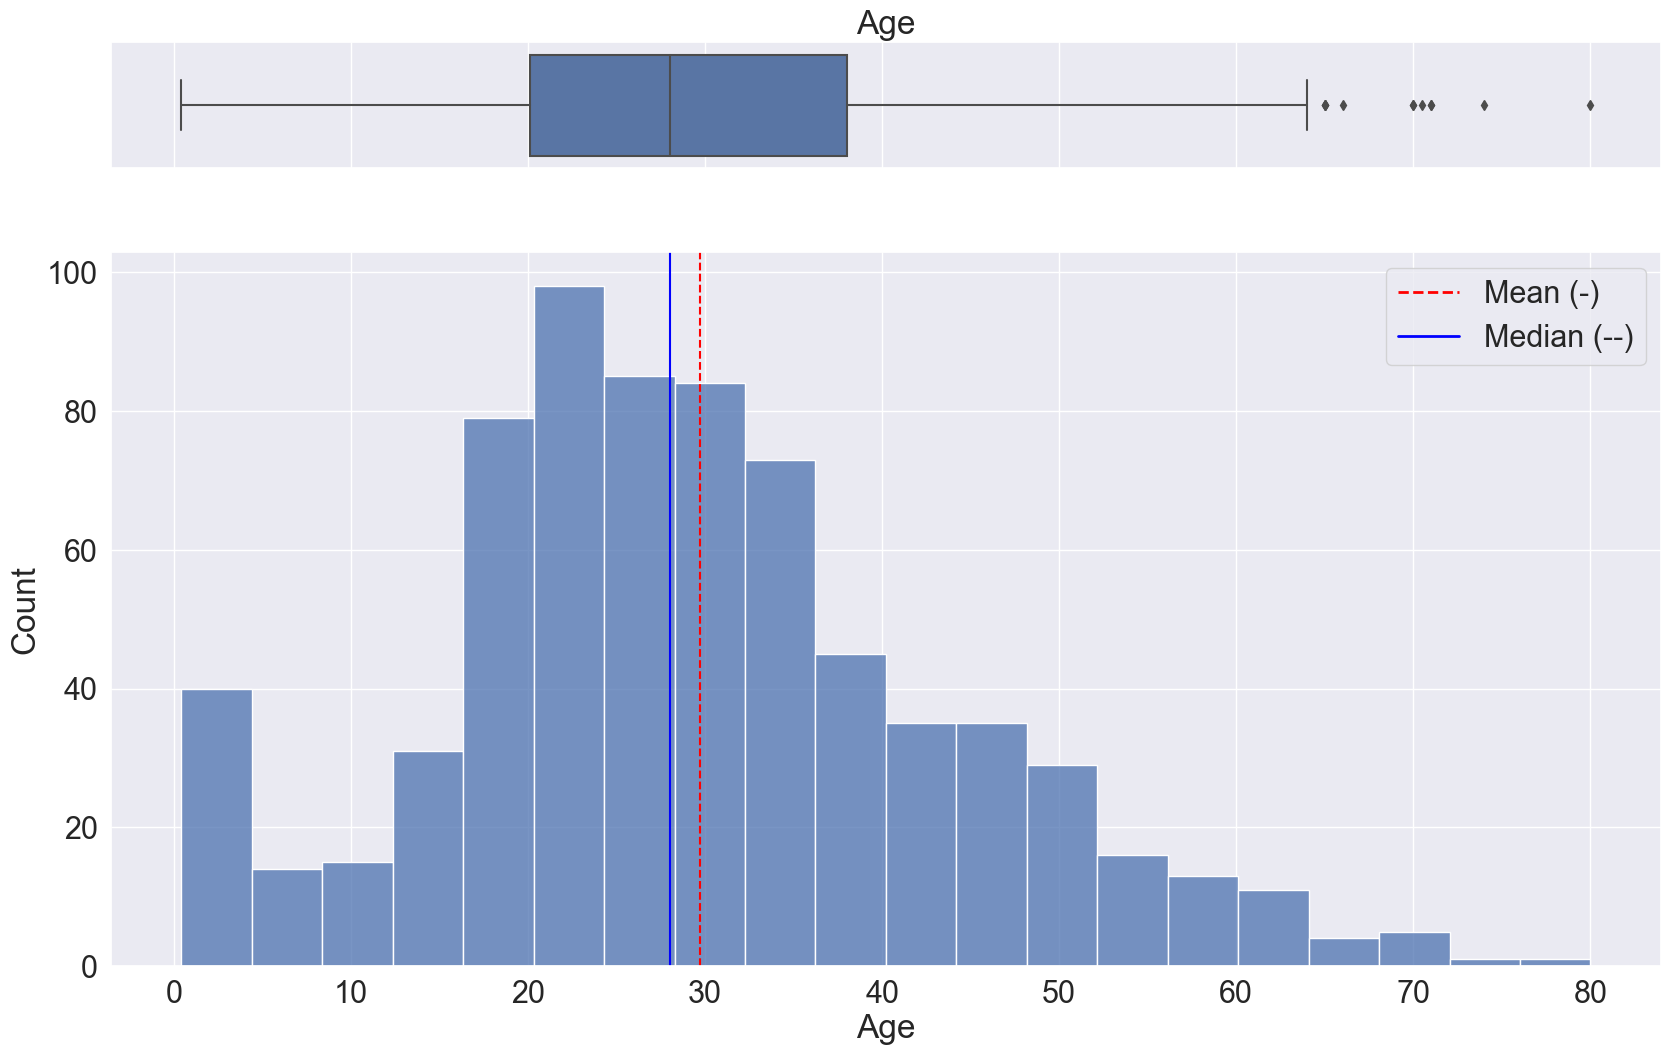

In [79]:
NuestrasFunciones.plot(df_titanic.Age)

In [80]:
df_investigacion3 = df_titanic[["Age","ParentsChildren","SiblingsSpouses","Survived"]]
#si no tiene ni SiblingsSpouses: puede ser only child o padre soltero o persona sin hijos soltera
#si no tiene ParentsChildren: es o niño que viaja solo o persona adulta sin hijos
#Niño sin hijos tuviese ParentsChildren = 0, Cabin única

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SiblingsSpouses', 'ParentsChildren', 'Ticket', 'Fare', 'Cabin',
       'Embarked', 'PostTicket', 'Cant_PersonasMismoTicket', 'PreTicket',
       'Porcentaje_PreTicket'],
      dtype='object')

In [234]:
df_titanic.isna().sum()

PassengerId                   0
Survived                      0
Pclass                        0
Name                          0
Sex                           0
Age                         177
SiblingsSpouses               0
ParentsChildren               0
Ticket                        0
Fare                          0
Cabin                       687
Embarked                      2
PostTicket                    0
Cant_PersonasMismoTicket      0
PreTicket                     0
Porcentaje_PreTicket          0
Apellido                      0
Cantidad_MismoApellido        0
Titulo                        0
dtype: int64

# Cabin con y sin mismo nombre

In [ ]:
###